テストデータに対して予測を行う
→それぞれの水分子の混合行列ごとに分ける
それぞれの水分子と最近接距離の距離を計算する

In [2]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import get_atom_coords_by_id, get_coordinates_from_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet
from models.ResNet_revised import ResNet_revised
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import fbeta_score, confusion_matrix
import numpy as np
from lib.plot import plot_histogram
from lib.helper import calculate_closest_distance, calculate_average_of_top_n_closest_distances, calculate_top_n_closest_coords
from SASA.ResSASACalculator import ResSASACalculator

2025-02-06 16:42:13.333809: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 16:42:13.531252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 16:42:13.569822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 16:42:13.574015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 16:42:13.821158: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import tensorflow as tf
# GPUを無効化
tf.config.set_visible_devices([], 'GPU')

In [4]:
DATA_TYPE1 = 'gr'
DATA_VOXEL_NUM = 20
CLASSIFYING_RULE = 'WaterClassifyingRuleEmbedding'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet'
TRAINER_NAME = 'aug_train'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
data_loader = SingleDataLoader(training_data_dir1)

In [5]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, 1)
n_base = 8
BN = True
checkpoint_dir = f'../checkpoints/valid_all/smoothing/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet(n_base=n_base, input_shape=input_shape, learning_rate=0.0, loss=BinaryCrossentropy(), metrics=[], BN=BN, class_num=2)
model.load_weights(latest_checkpoint)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 41, 41,    │          0 │ -                 │
│ (InputLayer)        │ 41, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 41, 41,    │        224 │ input_layer[0][0] │
│                     │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 41, 41,    │         32 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 41, 41,    │          0 │ batch_normalizat… │
│ (Activation)        │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 41, 41,    │      1,736 │ activation[0][0]  │
│                     │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │         32 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 41, 41,    │          0 │ batch_normalizat… │
│ (Activation)        │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 41, 41,    │      1,736 │ activation_1[0][… │
│                     │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │         32 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 41, 41,    │          0 │ batch_normalizat… │
│                     │ 41, 8)            │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 41, 41,    │          0 │ add[0][0]         │
│ (Activation)        │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 20, 20,    │          0 │ activation_2[0][… │
│ (MaxPooling3D)      │ 20, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 20, 20,    │      3,472 │ max_pooling3d[0]… │
│                     │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │         64 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (Activation)        │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 20, 20,    │      6,928 │ activation_3[0][… │
│                     │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 20, 20,    │        144 │ max_pooling3d[0]

 Total params: 58,114 (227.01 KB)

 Trainable params: 57,778 (225.70 KB)

 Non-trainable params: 336 (1.31 KB)

/home/ito/research/src/yuki_research/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
threshold = 0.5

In [20]:
data_dir = '../../data'
pdb_data_dir = '/mnt/ito/data/pdb_bind'
test_list = os.path.join(data_dir, 'all_valid_test.txt')
with open(test_list, 'r') as f:
    test_pdb_array = f.read().splitlines()
cm_for_each_pdb = {}
accuracy_for_each_pdb = {}
recall_for_each_pdb = {}
precision_for_each_pdb = {}
specificity_for_each_pdb = {}
negative_precision_for_each_pdb = {}

df = {'pdb_id': [], 
      'water_id': [], 
      'prediction_score': [], 
      'prediction_result': [], 
      'nearest_pro_atom_dist': [], 
      'nearest_lig_atom_dist': [], 
      'top_5_avg_pro_atom_dist': [], 
      'top_5_avg_lig_atom_dist': [], 
      'top_10_avg_pro_atom_dist': [],
      'top_10_avg_lig_atom_dist': [],
      'top_20_avg_pro_atom_dist': [],
      'top_20_avg_lig_atom_dist': [],
      'top_30_avg_pro_atom_dist': [],
      'top_30_avg_lig_atom_dist': [],
      'top_40_avg_pro_atom_dist': [],
      'top_40_avg_lig_atom_dist': [],
      'top_50_avg_pro_atom_dist': [],
      'top_50_avg_lig_atom_dist': [],
      'top_5_pro_lig_dist': [],
      'top_10_pro_lig_dist': [],
      'top_20_pro_lig_dist': [],
      'top_30_pro_lig_dist': [],
      'top_40_pro_lig_dist': [],
      'top_50_pro_lig_dist': [],
      'water_sasa': [],
}
for pdb in test_pdb_array:
    print(pdb)
    try:
        test_data_dis, water_ids_dis = data_loader.get_test_data_and_water_ids(pdb, 'displaceable')
        test_label_dis = np.array([1] * len(water_ids_dis))
        test_data_non_dis, water_ids_non_dis = data_loader.get_test_data_and_water_ids(pdb, 'non_displaceable')
        test_label_non_dis = np.array([0] * len(water_ids_non_dis))

        test_data = np.concatenate([test_data_dis, test_data_non_dis], axis=0)
        test_labels = np.concatenate([test_label_dis, test_label_non_dis], axis=0)
        test_water_ids = np.concatenate([water_ids_dis, water_ids_non_dis], axis=0)

        prediction = model.predict(test_data)
        predicted_label = (prediction[:, 1] >= threshold).astype(int)
        protein_coords = get_coordinates_from_pdb(os.path.join(pdb_data_dir, f'{pdb}/{pdb}_min.pdb'))
        ligand_coords = get_coordinates_from_pdb(os.path.join(pdb_data_dir, f'{pdb}/{pdb}_ligand.pdb'))

        for i in range(len(test_water_ids)):
            # {'pdb_id': '1a4y', 'water_id': 1, 'prediction_score': 0.23, 'prediction_result': 'TP', 'nearest_atom_dist': 2, }
            if test_labels[i] == 1 and predicted_label[i] == 1:
                prediction_result = 'TP'
            elif test_labels[i] == 1 and predicted_label[i] == 0:
                prediction_result = 'FN'
            elif test_labels[i] == 0 and predicted_label[i] == 1:
                prediction_result = 'FP'
            else:
                prediction_result = 'TN'
            df['pdb_id'].append(pdb)
            df['water_id'].append(test_water_ids[i])
            df['prediction_score'].append(prediction[i, 1])
            df['prediction_result'].append(prediction_result)
            water_coords = np.reshape(get_atom_coords_by_id(os.path.join(pdb_data_dir, f'{pdb}/pred_O_placed_{pdb}_3.0.pdb'), test_water_ids[i]), (1, 3))
            df['nearest_pro_atom_dist'].append(calculate_closest_distance(water_coords, protein_coords))
            df['nearest_lig_atom_dist'].append(calculate_closest_distance(water_coords, ligand_coords))
            df['top_5_avg_pro_atom_dist'].append(calculate_average_of_top_n_closest_distances(protein_coords, water_coords, 5))
            df['top_5_avg_lig_atom_dist'].append(calculate_average_of_top_n_closest_distances(ligand_coords, water_coords, 5))
            df['top_10_avg_pro_atom_dist'].append(calculate_average_of_top_n_closest_distances(protein_coords, water_coords, 10))
            df['top_10_avg_lig_atom_dist'].append(calculate_average_of_top_n_closest_distances(ligand_coords, water_coords, 10))
            df['top_20_avg_pro_atom_dist'].append(calculate_average_of_top_n_closest_distances(protein_coords, water_coords, 20))
            df['top_20_avg_lig_atom_dist'].append(calculate_average_of_top_n_closest_distances(ligand_coords, water_coords, 20))
            df['top_30_avg_pro_atom_dist'].append(calculate_average_of_top_n_closest_distances(protein_coords, water_coords, 30))
            df['top_30_avg_lig_atom_dist'].append(calculate_average_of_top_n_closest_distances(ligand_coords, water_coords, 30))
            df['top_40_avg_pro_atom_dist'].append(calculate_average_of_top_n_closest_distances(protein_coords, water_coords, 40))
            df['top_40_avg_lig_atom_dist'].append(calculate_average_of_top_n_closest_distances(ligand_coords, water_coords, 40))
            df['top_50_avg_pro_atom_dist'].append(calculate_average_of_top_n_closest_distances(protein_coords, water_coords, 50))
            df['top_50_avg_lig_atom_dist'].append(calculate_average_of_top_n_closest_distances(ligand_coords, water_coords, 50))
            top_5_pro_coords = calculate_top_n_closest_coords(protein_coords, water_coords, 5)
            top_5_lig_coords = calculate_top_n_closest_coords(ligand_coords, water_coords, 5)
            df['top_5_pro_lig_dist'].append(np.linalg.norm(np.mean(top_5_pro_coords, axis=0) - np.mean(top_5_lig_coords, axis=0)))
            top_10_pro_coords = calculate_top_n_closest_coords(protein_coords, water_coords, 10)
            top_10_lig_coords = calculate_top_n_closest_coords(ligand_coords, water_coords, 10)
            df['top_10_pro_lig_dist'].append(np.linalg.norm(np.mean(top_10_pro_coords, axis=0) - np.mean(top_10_lig_coords, axis=0)))
            top_20_pro_coords = calculate_top_n_closest_coords(protein_coords, water_coords, 20)
            top_20_lig_coords = calculate_top_n_closest_coords(ligand_coords, water_coords, 20)
            df['top_20_pro_lig_dist'].append(np.linalg.norm(np.mean(top_20_pro_coords, axis=0) - np.mean(top_20_lig_coords, axis=0)))
            top_30_pro_coords = calculate_top_n_closest_coords(protein_coords, water_coords, 30)
            top_30_lig_coords = calculate_top_n_closest_coords(ligand_coords, water_coords, 30)
            df['top_30_pro_lig_dist'].append(np.linalg.norm(np.mean(top_30_pro_coords, axis=0) - np.mean(top_30_lig_coords, axis=0)))
            top_40_pro_coords = calculate_top_n_closest_coords(protein_coords, water_coords, 40)
            top_40_lig_coords = calculate_top_n_closest_coords(ligand_coords, water_coords, 40)
            df['top_40_pro_lig_dist'].append(np.linalg.norm(np.mean(top_40_pro_coords, axis=0) - np.mean(top_40_lig_coords, axis=0)))
            top_50_pro_coords = calculate_top_n_closest_coords(protein_coords, water_coords, 50)
            top_50_lig_coords = calculate_top_n_closest_coords(ligand_coords, water_coords, 50)
            df['top_50_pro_lig_dist'].append(np.linalg.norm(np.mean(top_50_pro_coords, axis=0) - np.mean(top_50_lig_coords, axis=0)))
            res_sasa_calculator = ResSASACalculator(os.path.join(pdb_data_dir, f'{pdb}/water_sasa/water_sasa_{test_water_ids[i]}.pdb'), 'BCD')
            df['water_sasa'].append(res_sasa_calculator.calculate_res_sasa())
    except Exception as e:
        continue        



4l23


FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: atom 'BCD   O ' unknown, guessing element is ' O', and radius 1.520 A
FreeSASA: warning: at

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# pd.DataFrame(df).to_csv('prediction_analysis.csv', index=False)

In [5]:
result = pd.read_csv('prediction_analysis.csv')

In [6]:
result['prediction_score'] = 1 - result['prediction_score']

In [7]:
result

,pdb_id,water_id,prediction_score,prediction_result,nearest_pro_atom_dist,nearest_lig_atom_dist,top_5_avg_pro_atom_dist,top_5_avg_lig_atom_dist,top_10_avg_pro_atom_dist,top_10_avg_lig_atom_dist,...,top_40_avg_lig_atom_dist,top_50_avg_pro_atom_dist,top_50_avg_lig_atom_dist,top_5_pro_lig_dist,top_10_pro_lig_dist,top_20_pro_lig_dist,top_30_pro_lig_dist,top_40_pro_lig_dist,top_50_pro_lig_dist,water_sasa
0,4l23,1351,0.210838,TP,2.799360,2.780908,3.014673,3.504548,3.222430,4.018458,...,5.867351,5.005717,5.867351,4.132953,4.742399,5.758236,6.177402,6.160984,6.219637,9.514316
1,4l23,132,0.798743,FN,2.563798,2.291809,2.887017,4.127538,3.236624,5.353014,...,8.165977,4.884130,8.165977,3.985402,5.332850,7.071219,8.035060,8.206030,7.820983,1.493817
2,4l23,829,0.142133,TP,3.058070,1.126361,3.203972,2.503839,3.466734,3.791625,...,6.362240,5.083395,6.362240,4.009573,4.731554,5.338910,6.237791,6.485175,6.704140,8.070937
3,4l23,2675,0.216247,TP,3.029016,1.530888,3.246537,2.571703,3.937458,3.703136,...,6.851702,5.886004,6.851702,3.931119,4.757047,5.954757,7.172192,7.350979,6.955285,9.872127
4,4l23,1294,0.214535,TP,2.791545,0.860699,3.114997,1.657488,3.638809,2.746767,...,5.736247,5.272772,5.736247,2.892200,3.072698,4.944199,5.510383,5.932356,6.151989,10.387444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29109,2oei,1,0.700750,TN,2.784477,3.709499,3.066928,4.324543,3.380703,4.850158,...,6.884245,5.892535,7.803547,5.266497,4.964749,5.736038,6.894487,7.136195,7.152600,25.549349
29110,2oei,46,0.657538,TN,3.156014,5.211705,3.354429,5.917430,3.627579,6.617803,...,8.870044,6.446918,9.891943,5.628839,7.381776,7.434691,7.586077,8.382954,8.226427,41.135929
29111,2oei,125,0.635402,TN,2.895568,3.492831,3.918063,4.257811,4.949378,5.263063,...,7.793676,7.754139,9.059478,6.077201,7.715267,7.998086,7.920784,7.874872,7.797225,69.992493
29112,2oei,139,0.730883,TN,2.978643,4.387011,3.835087,5.689373,5.071191,6.491344,...,9.441993,8.506210,10.895729,6.351749,8.120355,9.138116,8.925751,8.744559,8.640810,67.608788


In [8]:
columns = result.columns
columns[4:]

Index(['nearest_pro_atom_dist', 'nearest_lig_atom_dist',
       'top_5_avg_pro_atom_dist', 'top_5_avg_lig_atom_dist',
       'top_10_avg_pro_atom_dist', 'top_10_avg_lig_atom_dist',
       'top_20_avg_pro_atom_dist', 'top_20_avg_lig_atom_dist',
       'top_30_avg_pro_atom_dist', 'top_30_avg_lig_atom_dist',
       'top_40_avg_pro_atom_dist', 'top_40_avg_lig_atom_dist',
       'top_50_avg_pro_atom_dist', 'top_50_avg_lig_atom_dist',
       'top_5_pro_lig_dist', 'top_10_pro_lig_dist', 'top_20_pro_lig_dist',
       'top_30_pro_lig_dist', 'top_40_pro_lig_dist', 'top_50_pro_lig_dist',
       'water_sasa'],
      dtype='object')

In [9]:
result_TP = result[result['prediction_result'] == 'TP']
result_FN = result[result['prediction_result'] == 'FN']
result_TN = result[result['prediction_result'] == 'TN']
result_FP = result[result['prediction_result'] == 'FP']
result_chikan = result[(result['prediction_result'] == 'TP') | (result['prediction_result'] == 'FN')]
result_hozon = result[(result['prediction_result'] == 'TN') | (result['prediction_result'] == 'FP')]

In [10]:
import pandas as pd

# 距離を区切る例
bins = [0, 1, 2, 3, 4, 5]  # 距離に応じた区切り値を設定
labels = ['0-3', '3-6', '6-9', '9-12', '12-15']
result_FP['dist_bin'] = pd.cut(result_FP['top_10_avg_pro_atom_dist'], bins=bins, labels=labels)

# dist_binごとにprediction_scoreの平均を確認
print(result_FP.groupby('dist_bin')['prediction_score'].mean())

# 箱ひげ図（Seaborn）
sns.boxplot(x='dist_bin', y='prediction_score', data=result_FP)


dist_bin
0-3           NaN
3-6           NaN
6-9      0.371627
9-12     0.349115
12-15    0.372966
Name: prediction_score, dtype: float64


/tmp/ipykernel_3174292/640423448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_FP['dist_bin'] = pd.cut(result_FP['top_10_avg_pro_atom_dist'], bins=bins, labels=labels)
/tmp/ipykernel_3174292/640423448.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(result_FP.groupby('dist_bin')['prediction_score'].mean())


NameError: name 'sns' is not defined

In [11]:
import numpy as np

dist_array = result_chikan['nearest_lig_atom_dist'].values
score_array = result_chikan['prediction_score'].values

pearson_corr = np.corrcoef(dist_array, score_array)[0, 1]
print("Pearson correlation:", pearson_corr)

# # スピアマン相関
# import scipy.stats as st
# spearman_corr, _ = st.spearmanr(dist_array, score_array)
# print("Spearman correlation:", spearman_corr)


Pearson correlation: 0.2699401184579973


In [12]:
result_TN

,pdb_id,water_id,prediction_score,prediction_result,nearest_pro_atom_dist,nearest_lig_atom_dist,top_5_avg_pro_atom_dist,top_5_avg_lig_atom_dist,top_10_avg_pro_atom_dist,top_10_avg_lig_atom_dist,...,top_40_avg_lig_atom_dist,top_50_avg_pro_atom_dist,top_50_avg_lig_atom_dist,top_5_pro_lig_dist,top_10_pro_lig_dist,top_20_pro_lig_dist,top_30_pro_lig_dist,top_40_pro_lig_dist,top_50_pro_lig_dist,water_sasa
16,4l23,1086,0.840143,TN,2.839747,5.693653,3.046992,6.759049,3.442084,8.178407,...,10.795814,5.190280,10.795814,6.170820,7.346020,8.484041,9.088785,8.747867,8.603687,8.800864
17,4l23,1029,0.705049,TN,2.871837,5.556385,3.141137,6.733172,3.427827,8.324492,...,11.183340,5.518192,11.183340,4.814126,6.385137,8.402080,9.234176,9.316580,9.052829,16.565952
18,4l23,1410,0.702604,TN,3.062582,6.384545,3.182183,7.240101,3.457412,8.489502,...,11.169910,5.246595,11.169910,6.209514,7.018192,8.966161,9.723377,9.958325,9.854103,9.814001
19,4l23,92,0.817662,TN,2.719772,5.571433,2.943817,6.366960,3.185791,7.898458,...,11.417985,4.689225,11.417985,6.718980,7.846066,10.755136,12.294310,12.133889,11.984871,5.194371
20,4l23,791,0.689507,TN,2.760061,4.269733,3.169516,5.188108,3.533990,6.469844,...,9.762841,5.429019,9.762841,5.538030,7.283531,10.201092,10.021884,10.165131,10.112895,13.049347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29109,2oei,1,0.700750,TN,2.784477,3.709499,3.066928,4.324543,3.380703,4.850158,...,6.884245,5.892535,7.803547,5.266497,4.964749,5.736038,6.894487,7.136195,7.152600,25.549349
29110,2oei,46,0.657538,TN,3.156014,5.211705,3.354429,5.917430,3.627579,6.617803,...,8.870044,6.446918,9.891943,5.628839,7.381776,7.434691,7.586077,8.382954,8.226427,41.135929
29111,2oei,125,0.635402,TN,2.895568,3.492831,3.918063,4.257811,4.949378,5.263063,...,7.793676,7.754139,9.059478,6.077201,7.715267,7.998086,7.920784,7.874872,7.797225,69.992493
29112,2oei,139,0.730883,TN,2.978643,4.387011,3.835087,5.689373,5.071191,6.491344,...,9.441993,8.506210,10.895729,6.351749,8.120355,9.138116,8.925751,8.744559,8.640810,67.608788


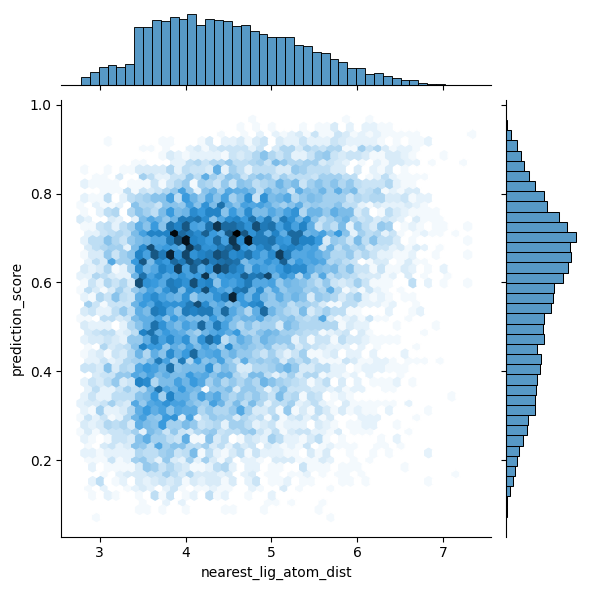

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# プロット作成
g = sns.jointplot(
    x='nearest_lig_atom_dist',
    y='prediction_score',
    data=result_hozon,
    kind='hex',
    gridsize=50  # デフォルトは30、数値を大きくすると分割が細かくなる
)

# X 軸の目盛りを細かく
g.ax_joint.locator_params(axis="x", nbins=10)  # X 軸の目盛りを増やす

plt.show()


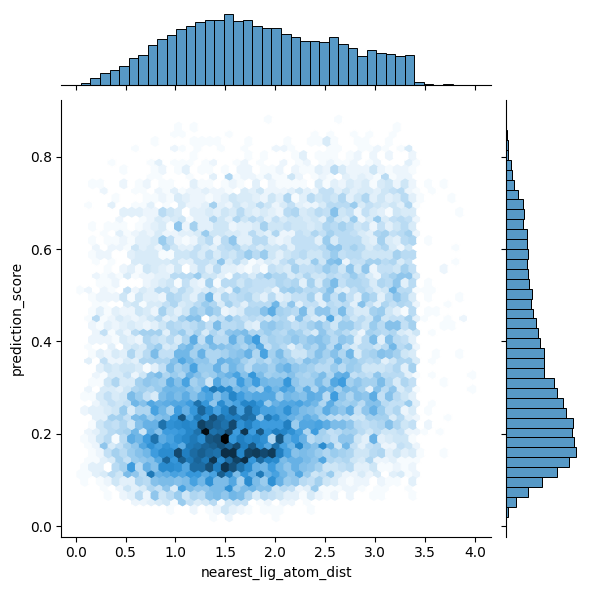

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# プロット作成
g = sns.jointplot(
    x='nearest_lig_atom_dist',
    y='prediction_score',
    data=result_chikan,
    kind='hex',
    gridsize=50  # デフォルトは30、数値を大きくすると分割が細かくなる
)

# X 軸の目盛りを細かく
g.ax_joint.locator_params(axis="x", nbins=10)  # X 軸の目盛りを増やす

plt.show()


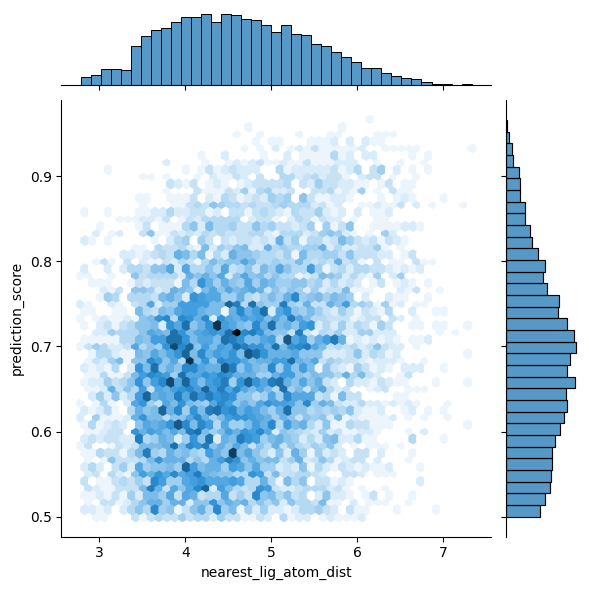

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# プロット作成
g = sns.jointplot(
    x='nearest_lig_atom_dist',
    y='prediction_score',
    data=result_TN,
    kind='hex',
    gridsize=50  # デフォルトは30、数値を大きくすると分割が細かくなる
)

# X 軸の目盛りを細かく
g.ax_joint.locator_params(axis="x", nbins=10)  # X 軸の目盛りを増やす

plt.show()


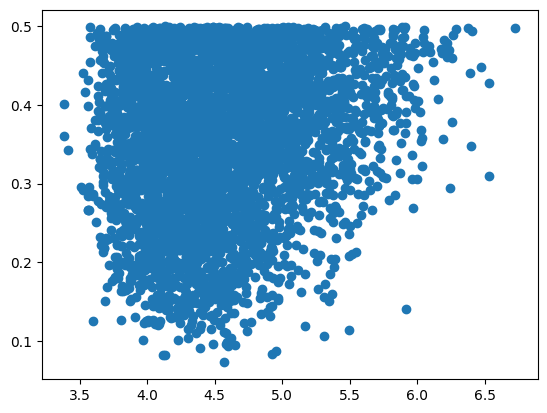

In [16]:
plt.scatter(result_FP['top_20_avg_pro_atom_dist'], result_FP['prediction_score'])

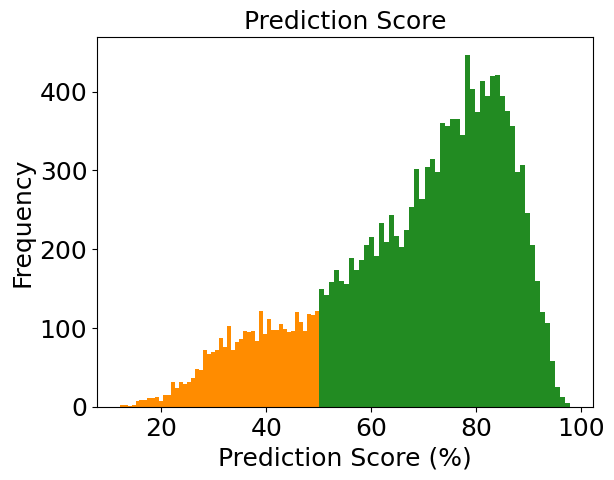

In [17]:
plt.hist((1-result_TP['prediction_score'])*100, bins=50, label='True Negative', color='forestgreen')
plt.hist((1-result_FN['prediction_score'])*100, bins=50, label='False Positive', color='darkorange')
plt.title('Prediction Score', fontsize='18')
plt.xlabel('Prediction Score (%)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.legend()
plt.show()

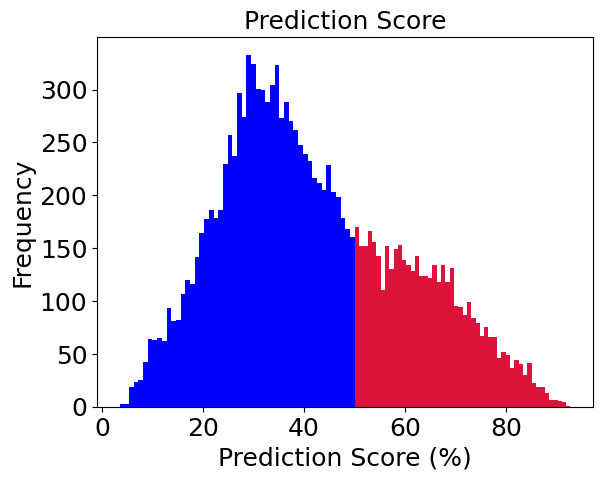

In [18]:
plt.hist((1-result_TN['prediction_score'])*100, bins=50, label='True Positive', color='blue')
plt.hist((1-result_FP['prediction_score'])*100, bins=50, label='False Negative', color='crimson')
plt.title('Prediction Score', fontsize='18')
plt.xlabel('Prediction Score (%)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.legend()
plt.show()

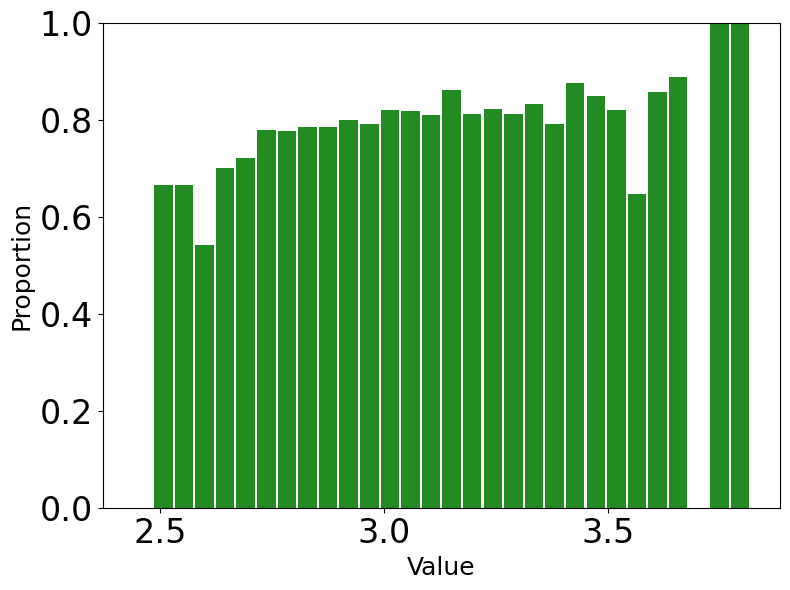

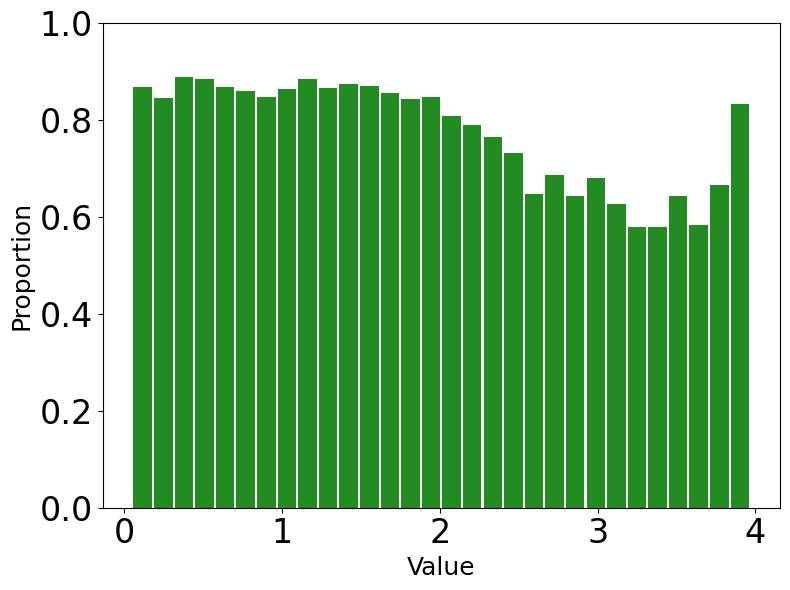

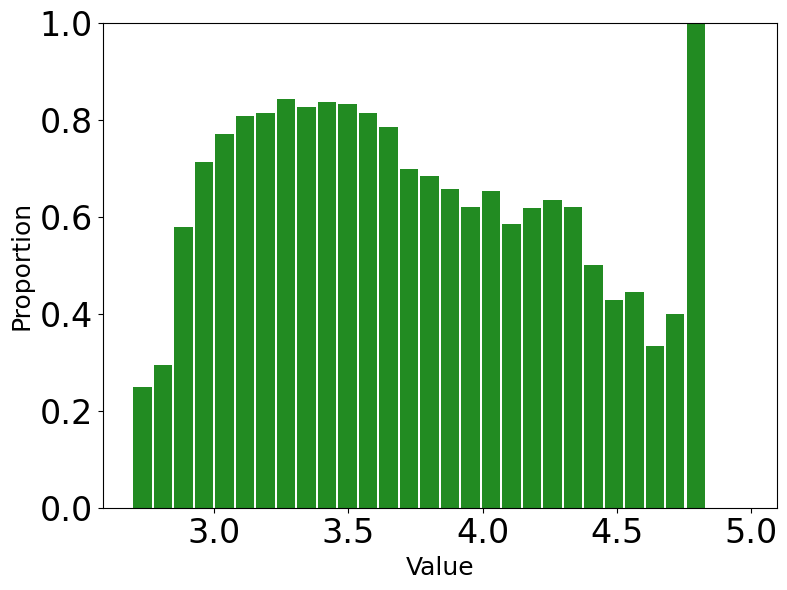

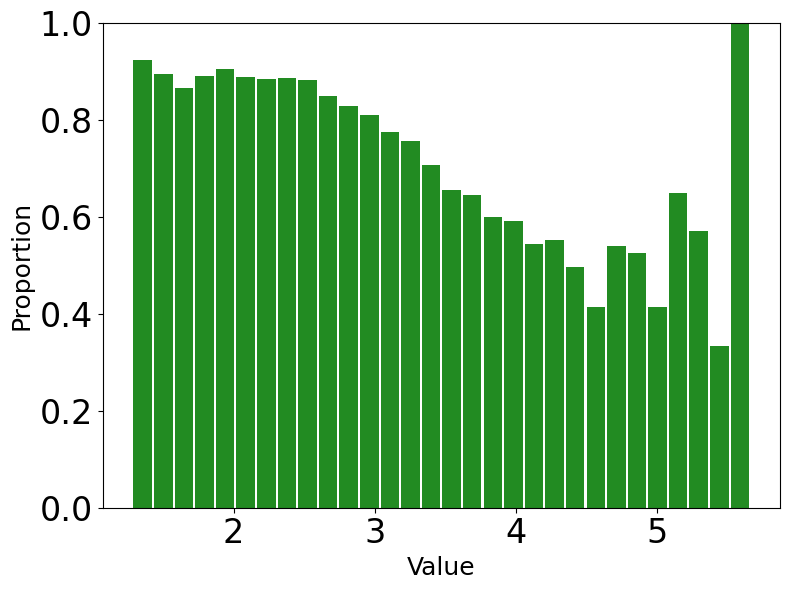

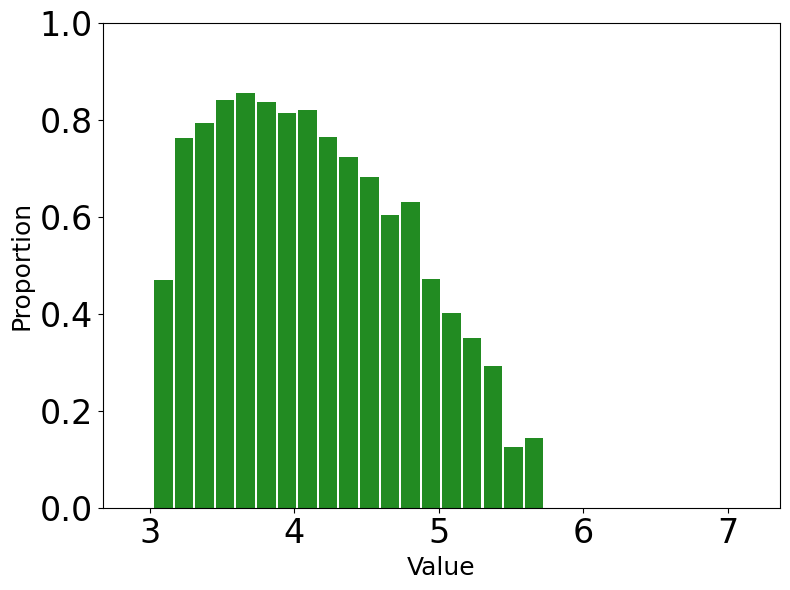

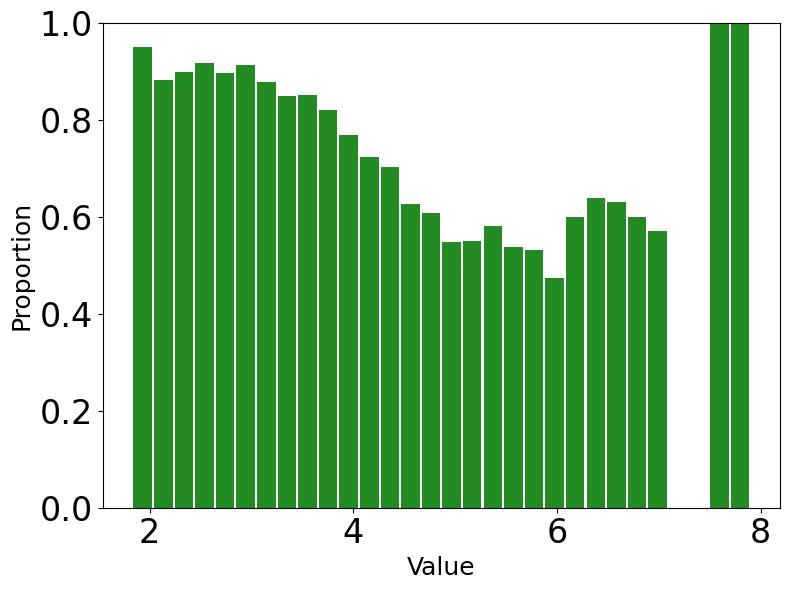

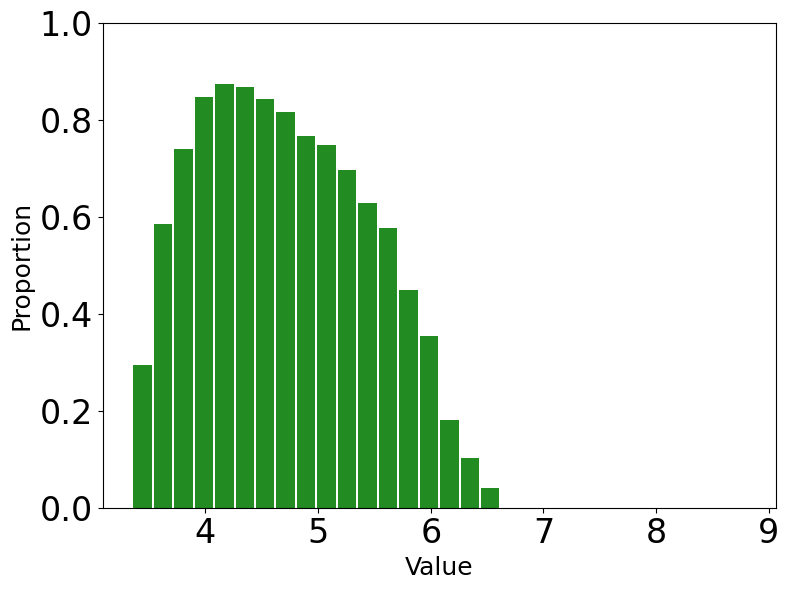

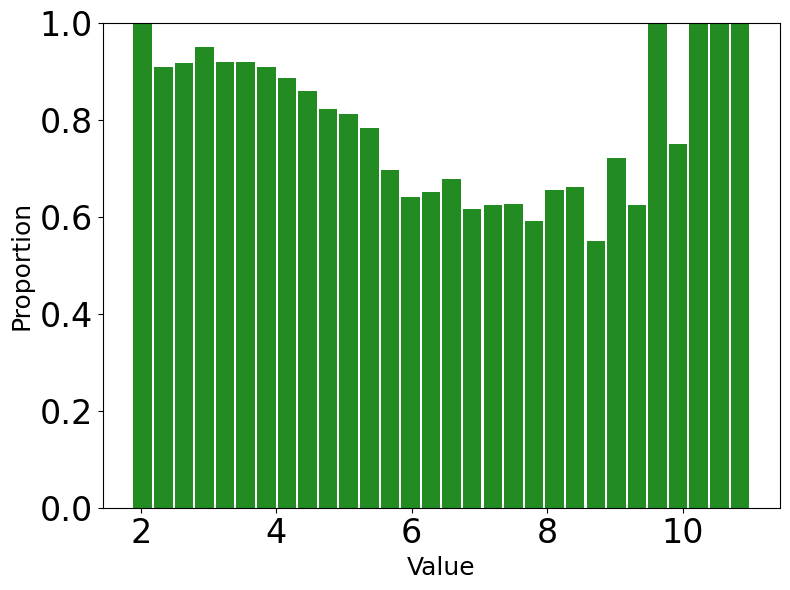

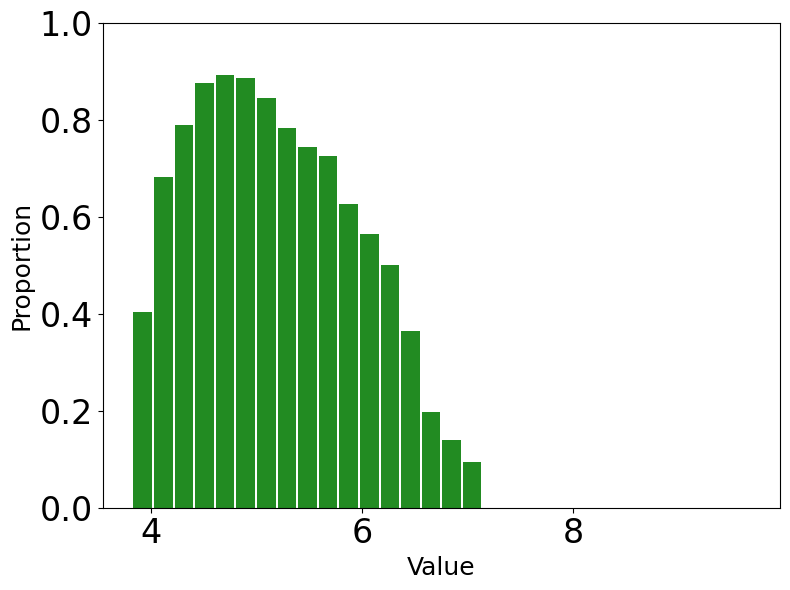

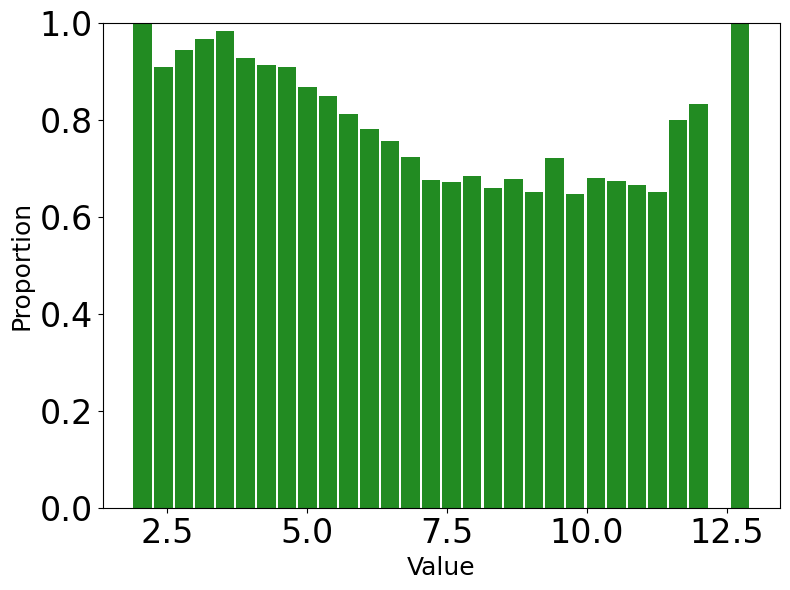

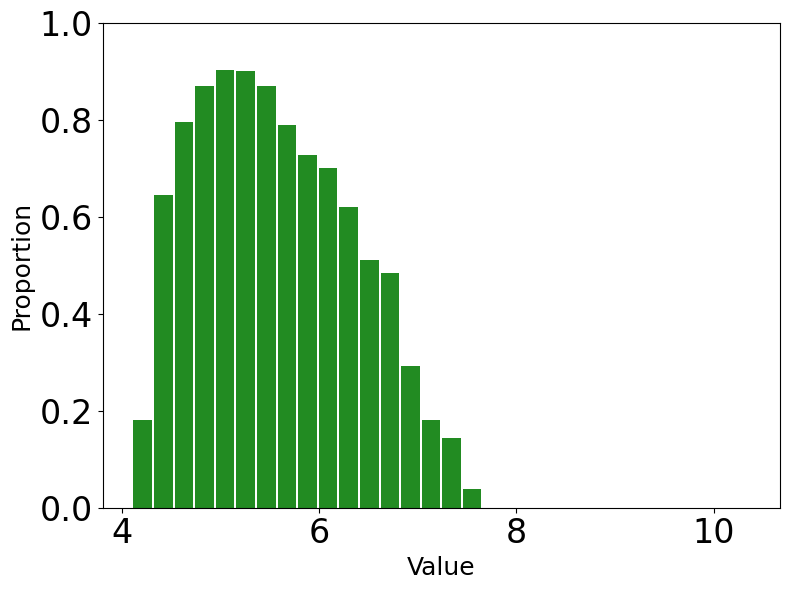

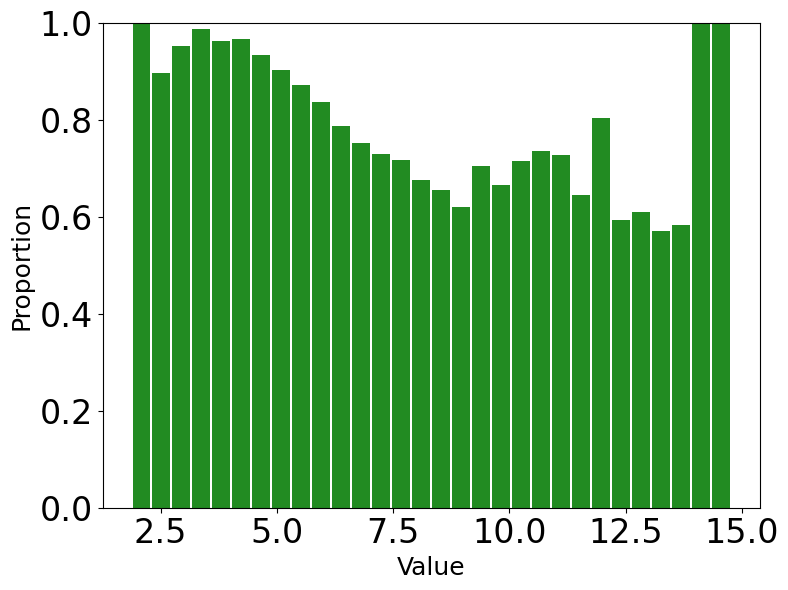

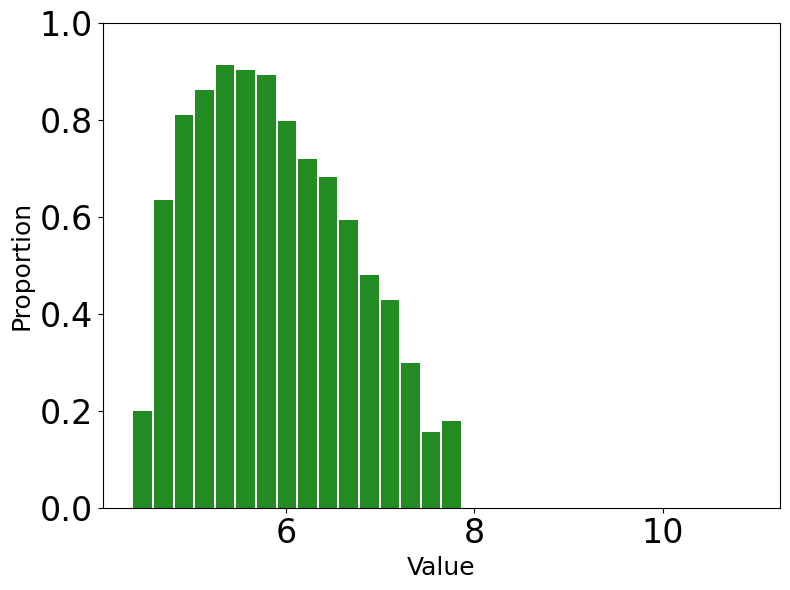

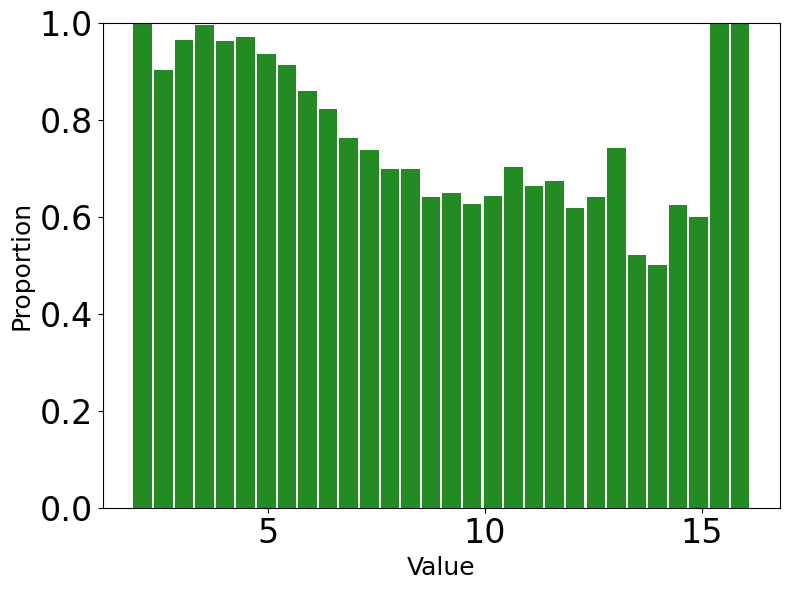

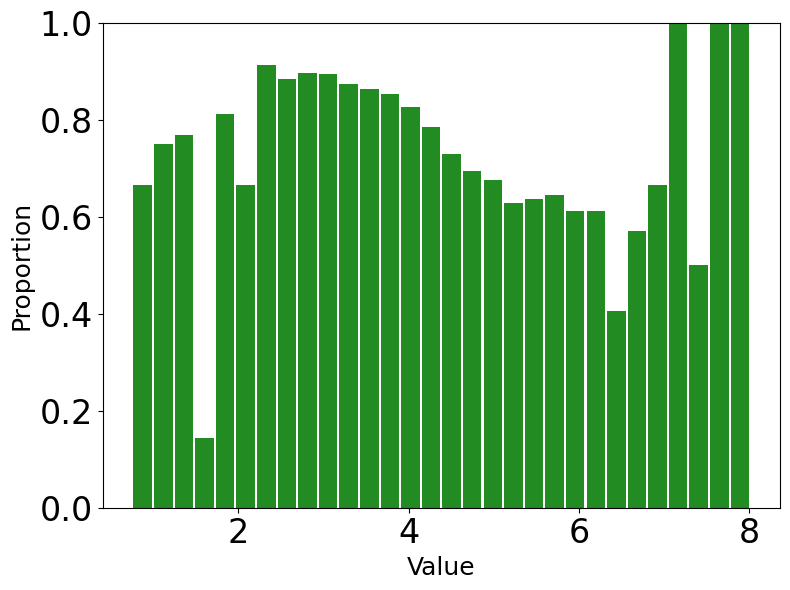

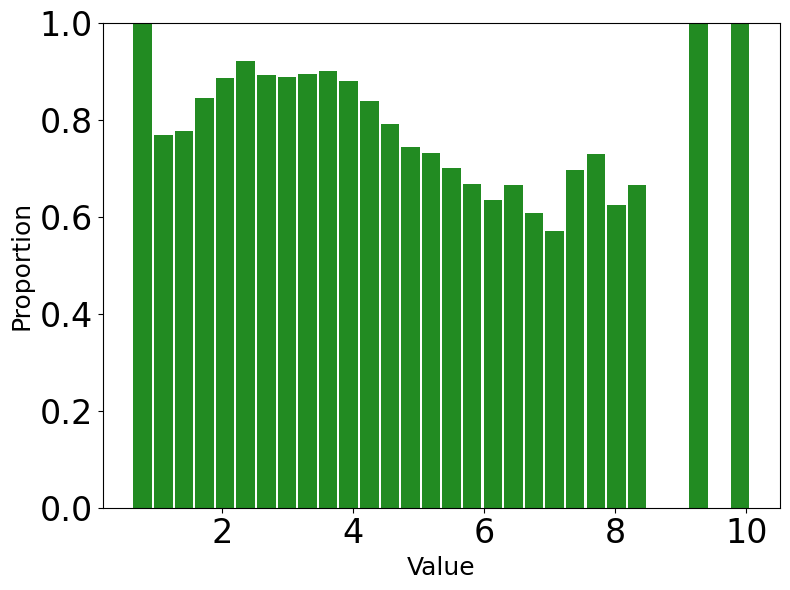

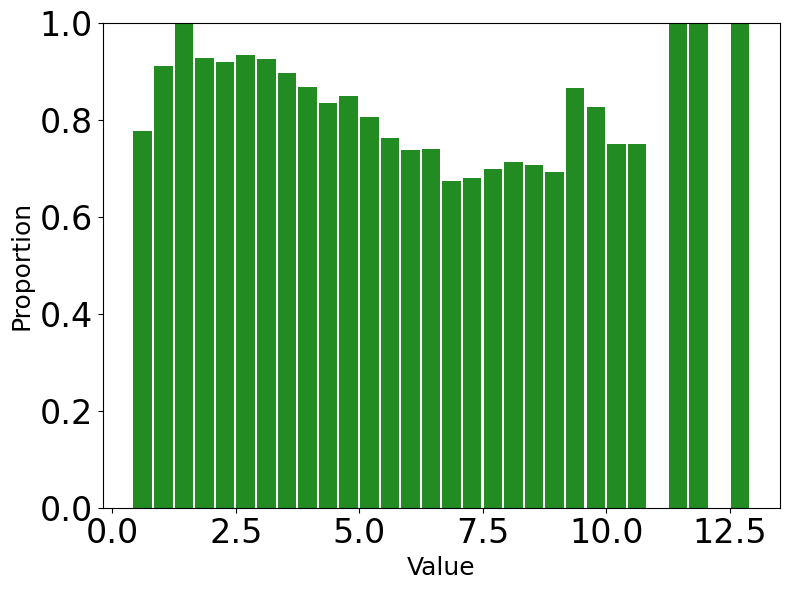

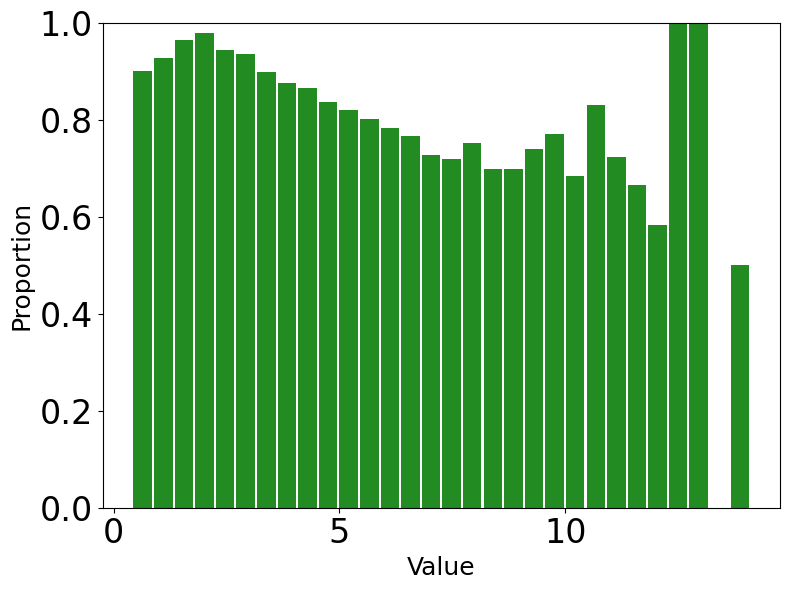

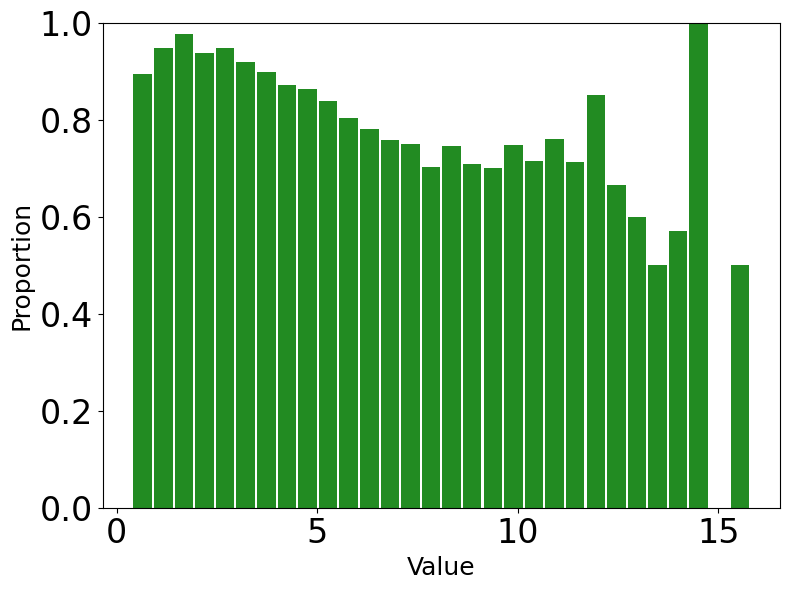

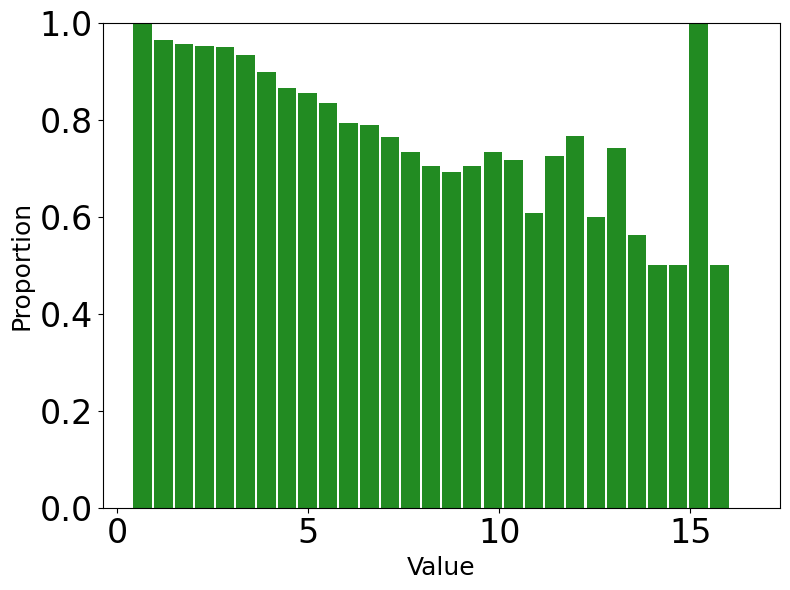

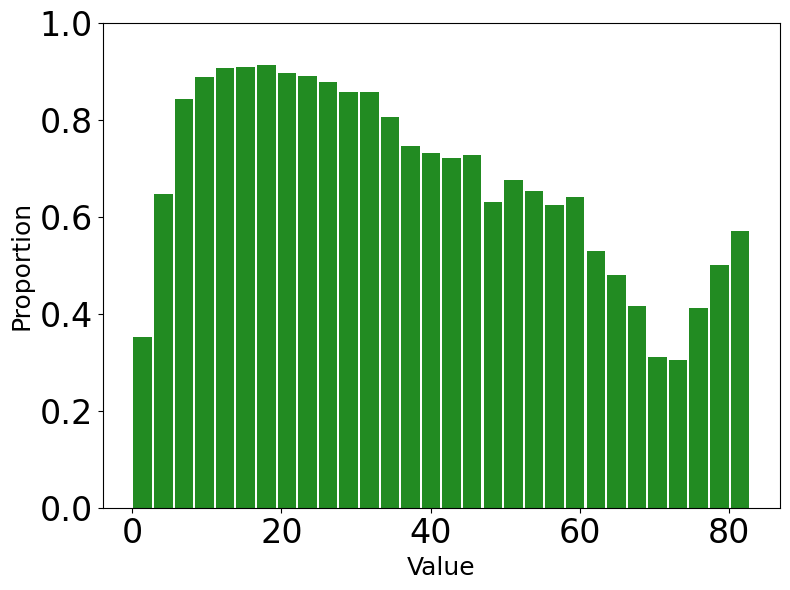

In [19]:
for column_name in columns[4:]:
    # 必要な初期値を計算
    bins = 30  # ヒストグラムのビン数
    MIN = min(result_TP[column_name].min(), result_FN[column_name].min())
    MAX = max(result_TP[column_name].max(), result_FN[column_name].max())
    width = (MAX - MIN) / bins
    bins_edges = np.linspace(MIN, MAX, bins + 1)
    data_points = bins_edges[:-1] + width / 2  # ビンの中心点を計算

    # ヒストグラムのデータを計算
    n1, _ = np.histogram(result_TP[column_name], bins=bins_edges)
    n2, _ = np.histogram(result_FN[column_name], bins=bins_edges)
    
    # 各データを正規化
    n1_P = n1 / n1.sum()
    n2_P = n2 / n2.sum()

    # 積み上げの割合を計算
    n1_stacked = n1 / (n1 + n2 + 1e-8)  # 0割りを防ぐために微小値を加算
    n2_stacked = n2_P / (n1_P + n2_P + 1e-8)

    # グラフの描画
    plt.figure(figsize=(8, 6))
    plt.bar(data_points, n1_stacked, width=width * 0.9, color="forestgreen", label='True Negative')
    # plt.bar(data_points, n2_stacked, bottom=n1_stacked, width=width * 0.9, color="darkorange", label='False Positive')
    plt.ylim(0, 1)
    # ラベル、タイトル、凡例を設定
    # plt.title(column_name, fontsize=16)
    plt.xlabel('Value', fontsize=18)
    plt.ylabel('Proportion', fontsize=18)
    # plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.tight_layout()
    plt.show()


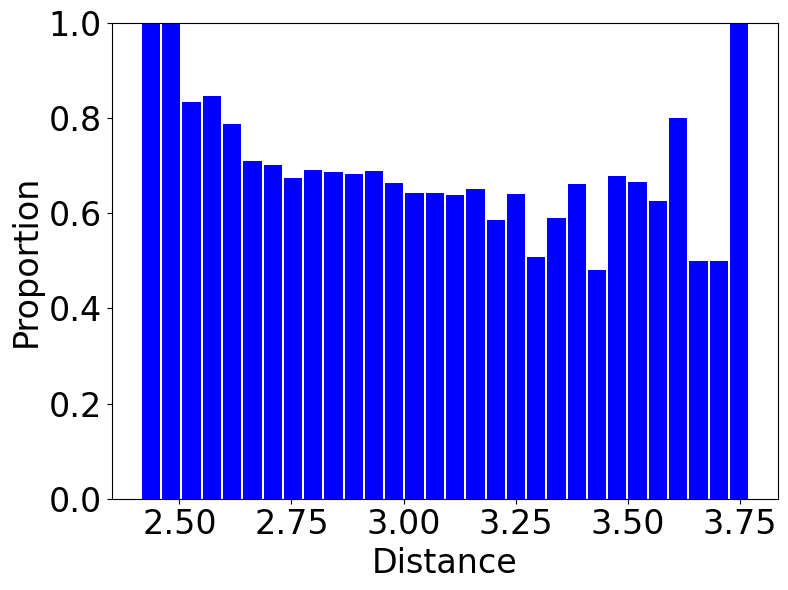

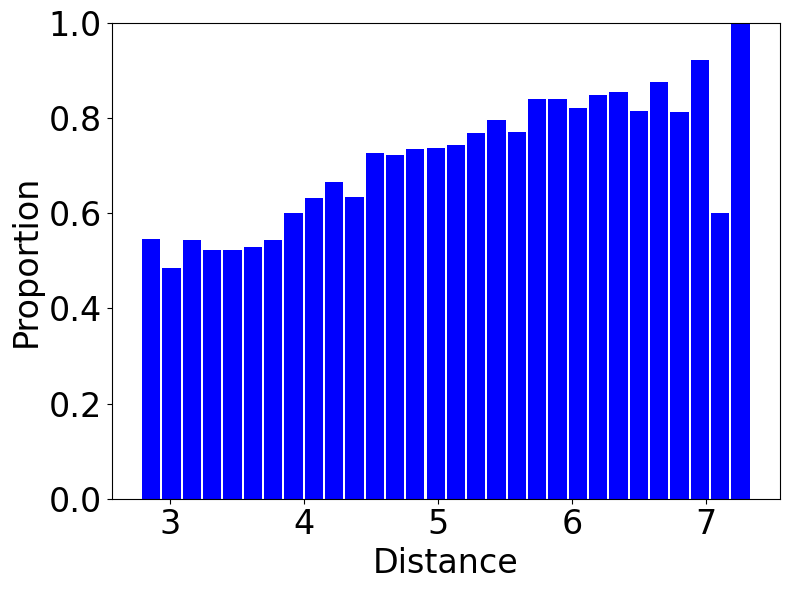

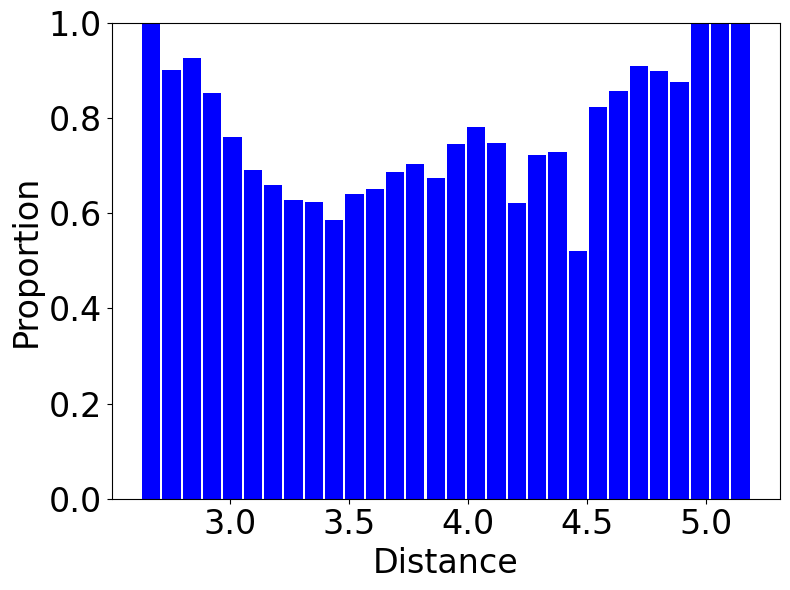

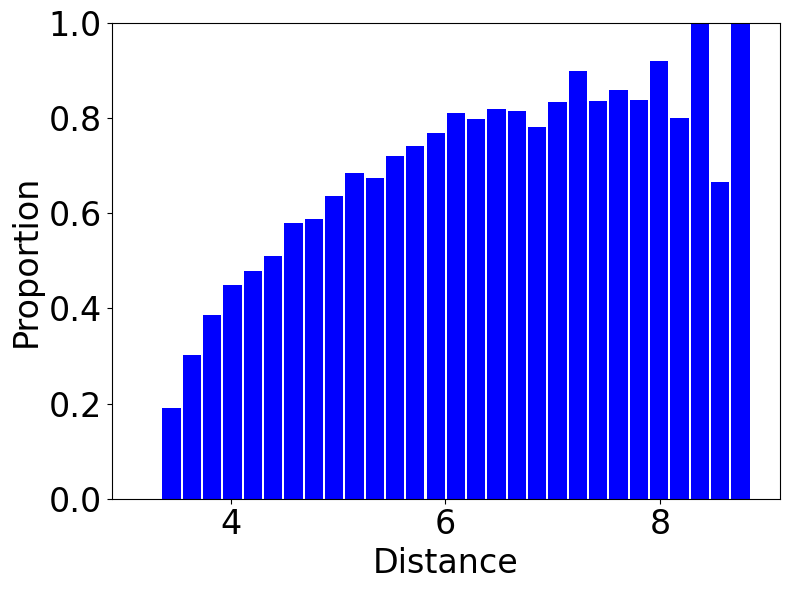

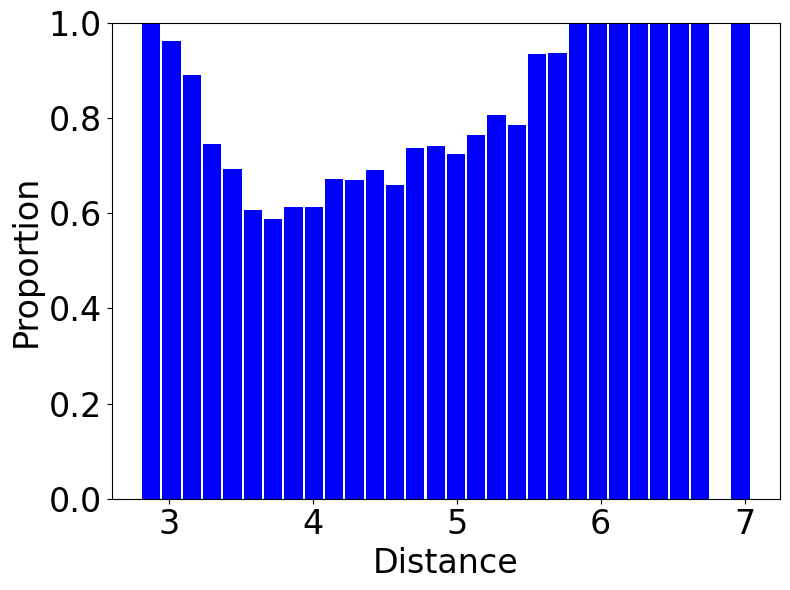

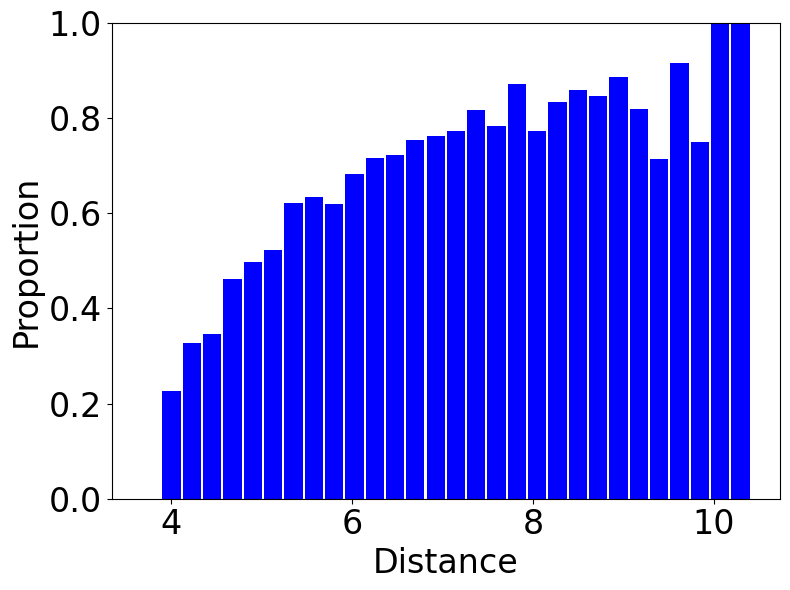

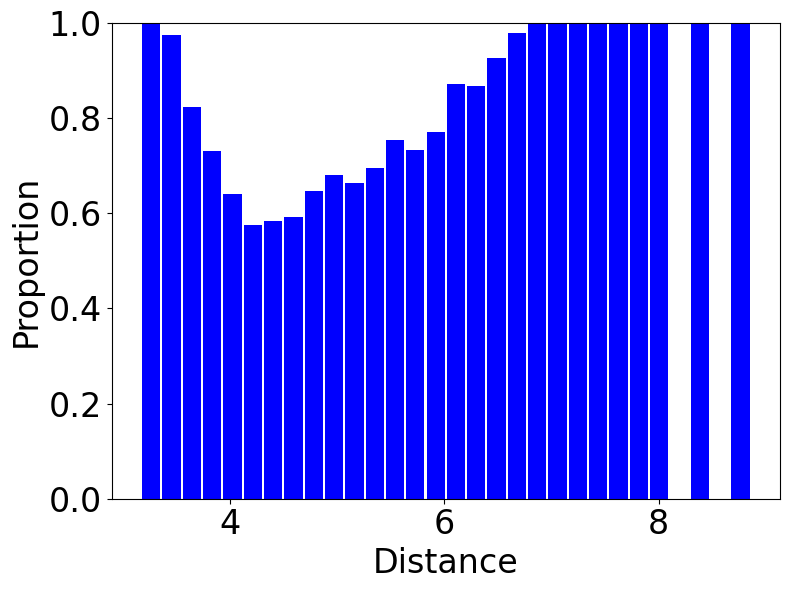

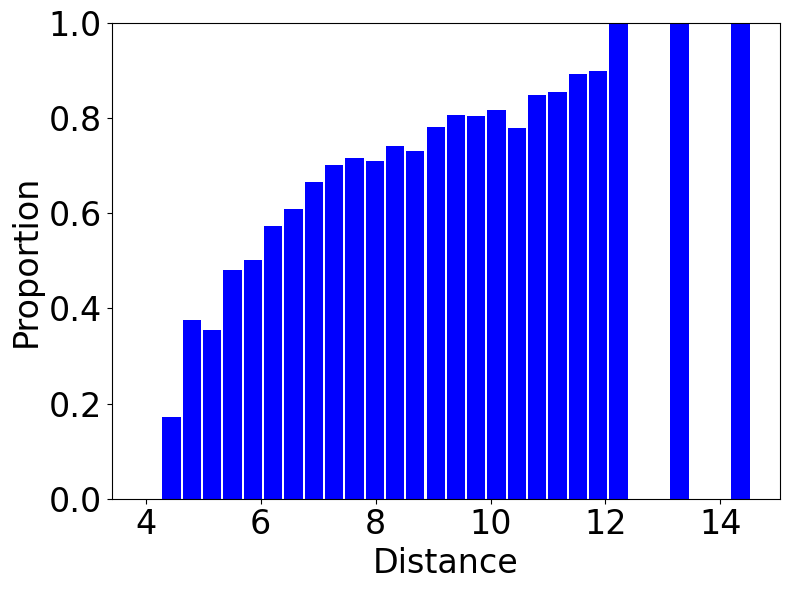

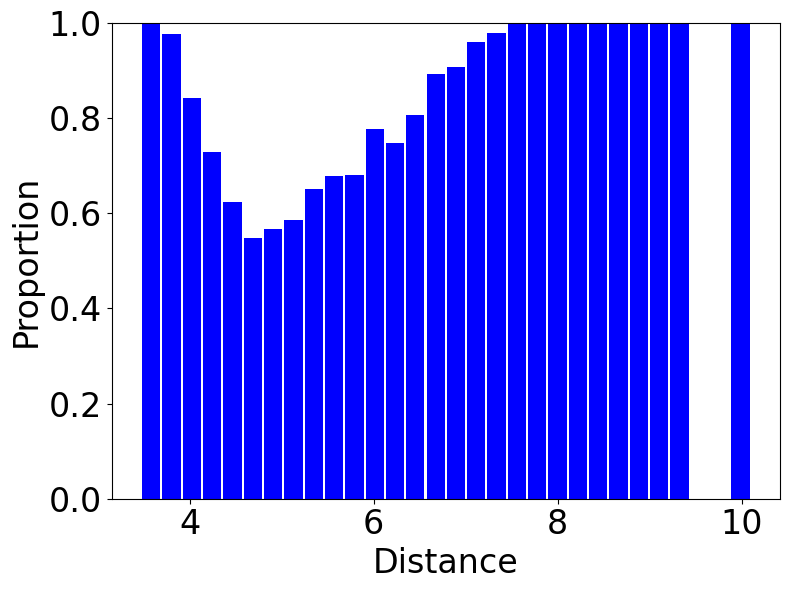

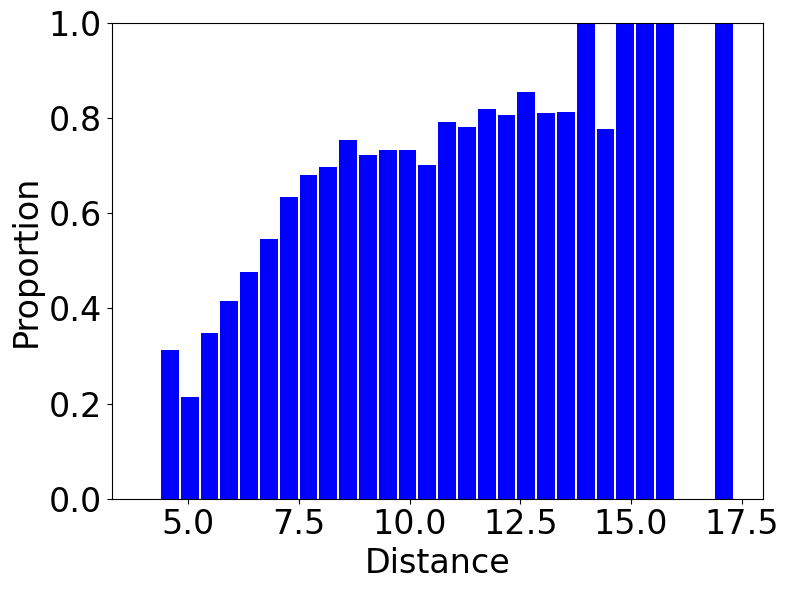

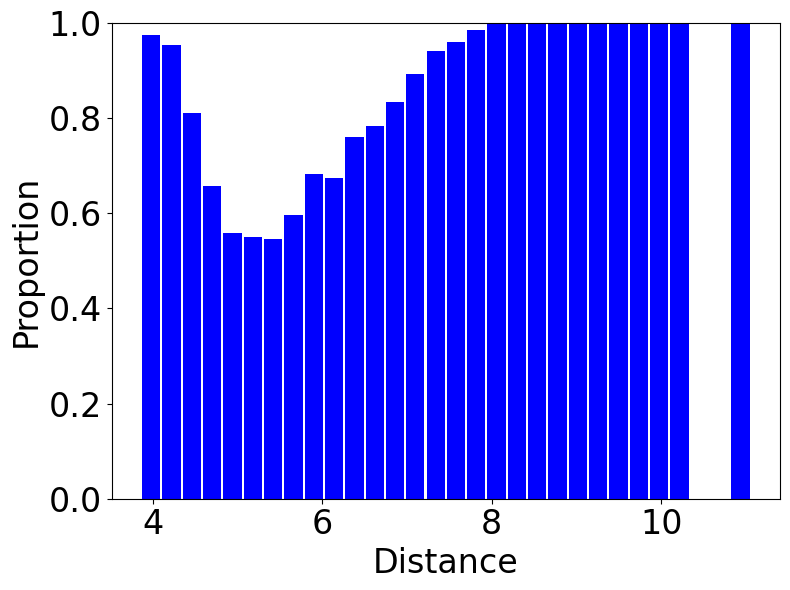

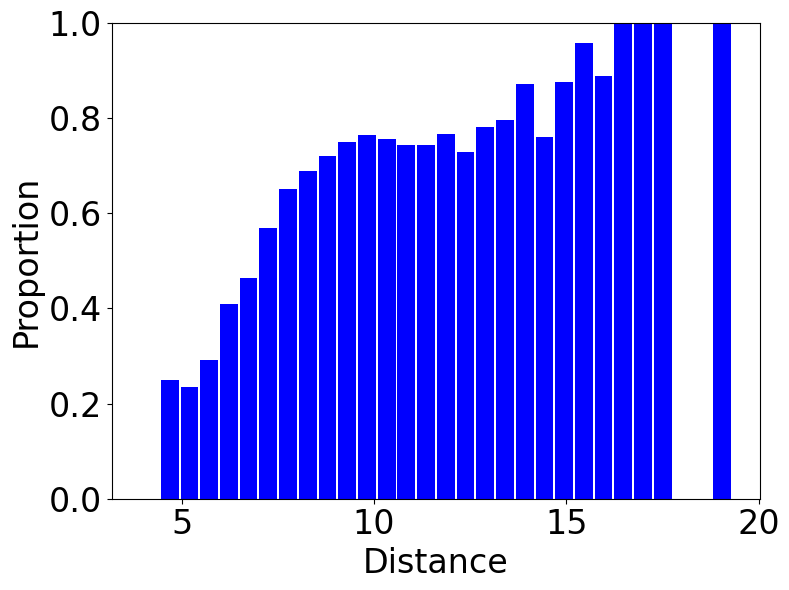

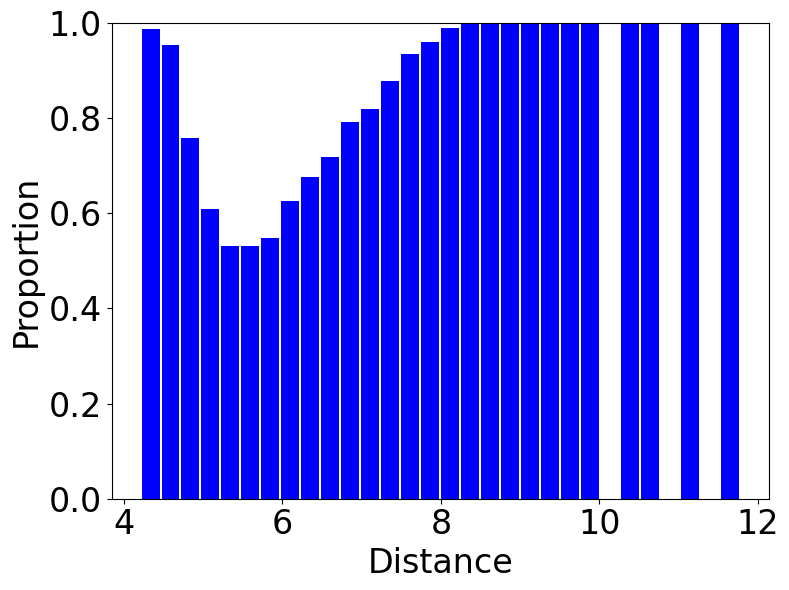

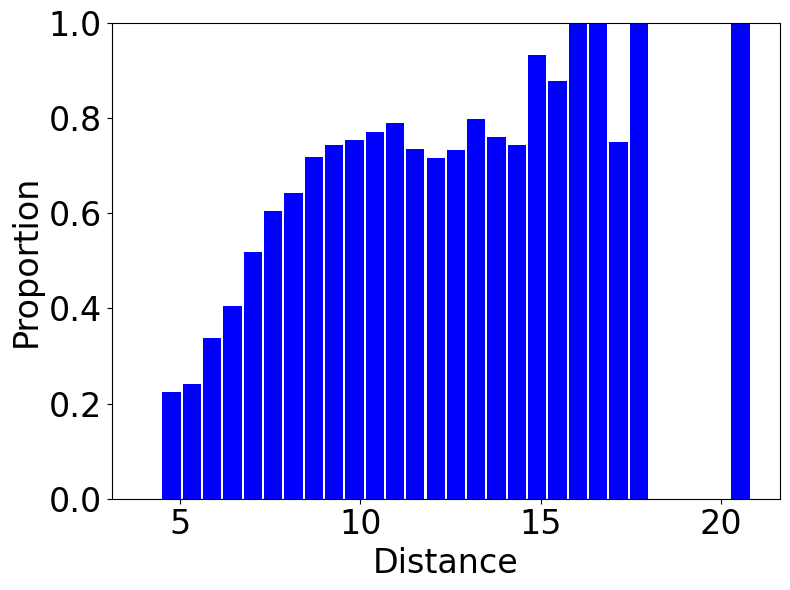

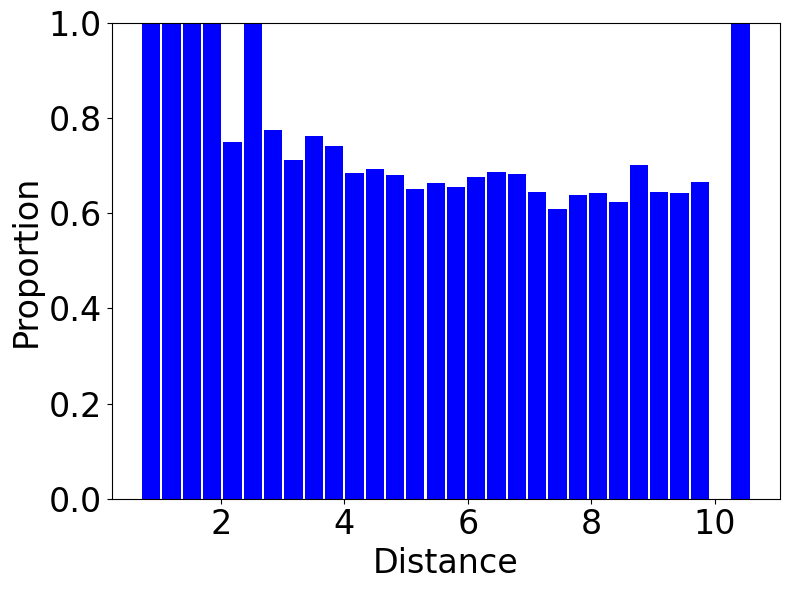

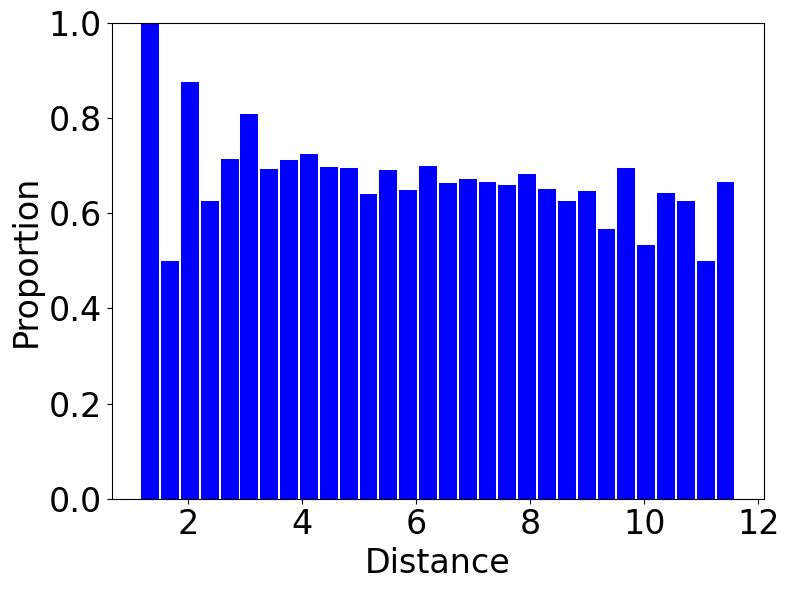

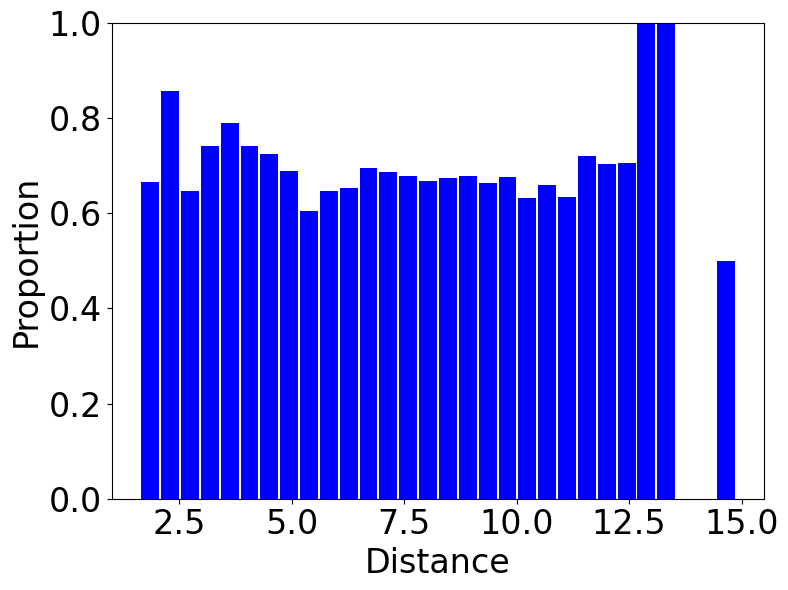

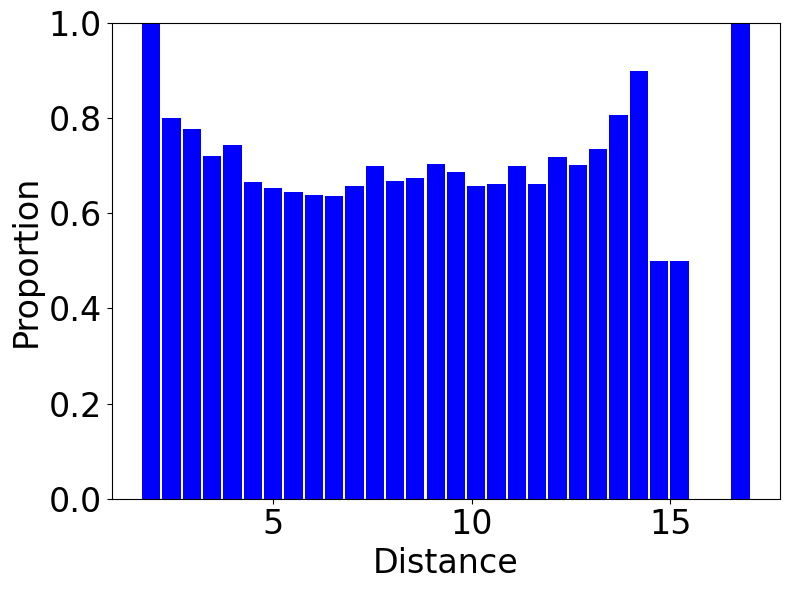

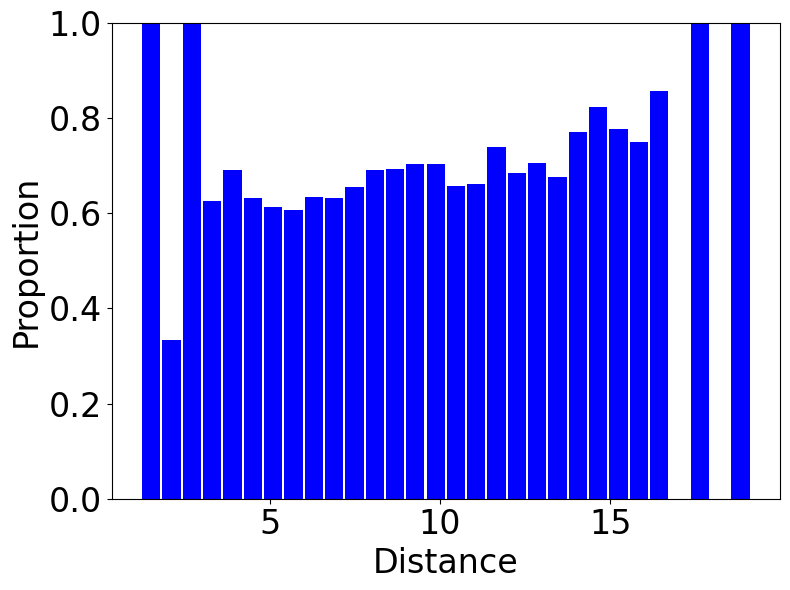

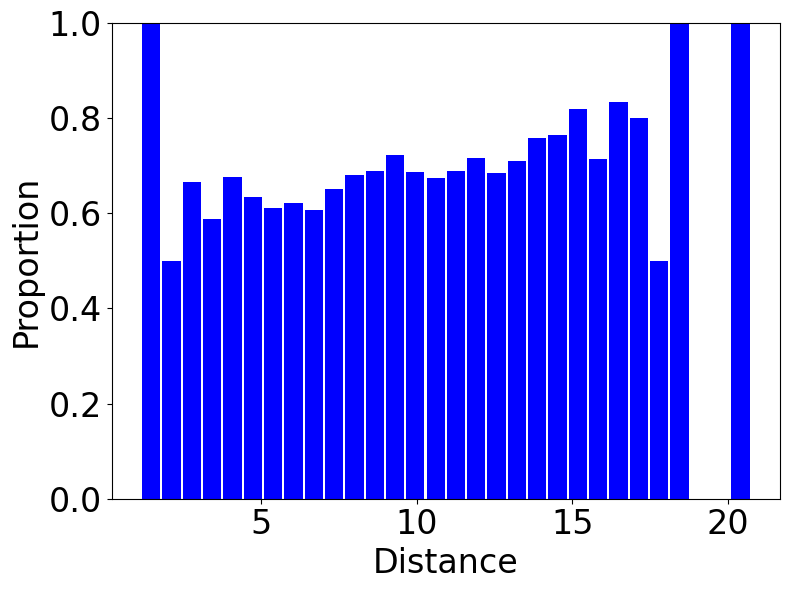

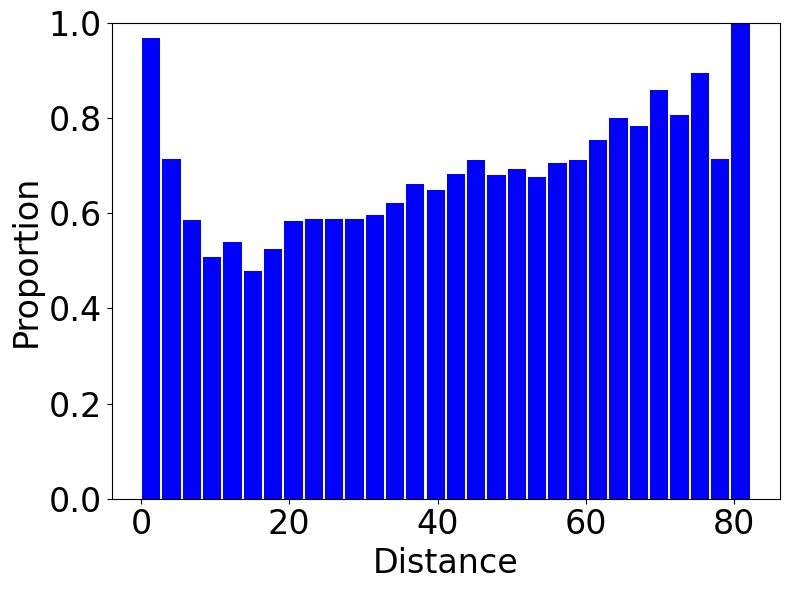

In [20]:
for column_name in columns[4:]:
    # 必要な初期値を計算
    bins = 30  # ヒストグラムのビン数
    MIN = min(result_TN[column_name].min(), result_FP[column_name].min())
    MAX = max(result_TN[column_name].max(), result_FP[column_name].max())
    width = (MAX - MIN) / bins
    bins_edges = np.linspace(MIN, MAX, bins + 1)
    data_points = bins_edges[:-1] + width / 2  # ビンの中心点を計算

    # ヒストグラムのデータを計算
    n1, _ = np.histogram(result_TN[column_name], bins=bins_edges)
    n2, _ = np.histogram(result_FP[column_name], bins=bins_edges)
    
    # 各データを正規化
    n1_P = n1 / n1.sum()
    n2_P = n2 / n2.sum()

    # 積み上げの割合を計算
    n1_stacked = n1 / (n1 + n2 + 1e-8)  # 0割りを防ぐために微小値を加算
    n2_stacked = n2_P / (n1_P + n2_P + 1e-8)

    # グラフの描画
    plt.figure(figsize=(8, 6))
    plt.bar(data_points, n1_stacked, width=width * 0.9, color="blue", label='True Positive')
    # plt.bar(data_points, n2_stacked, bottom=n1_stacked, width=width * 0.9, color="crimson", label='False Negative')
    plt.ylim(0, 1)
    # ラベル、タイトル、凡例を設定
    # plt.title(column_name, fontsize=16)
    plt.xlabel('Distance', fontsize=24)
    plt.ylabel('Proportion', fontsize=24)
    # plt.legend(fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.tight_layout()
    plt.show()


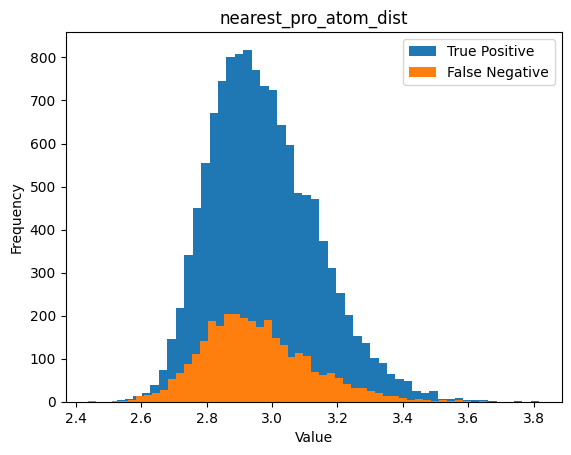

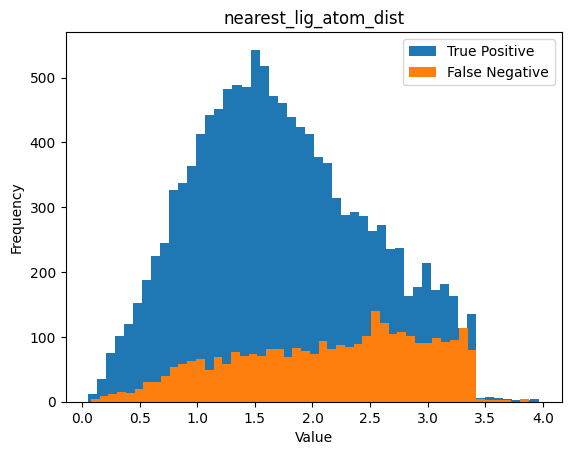

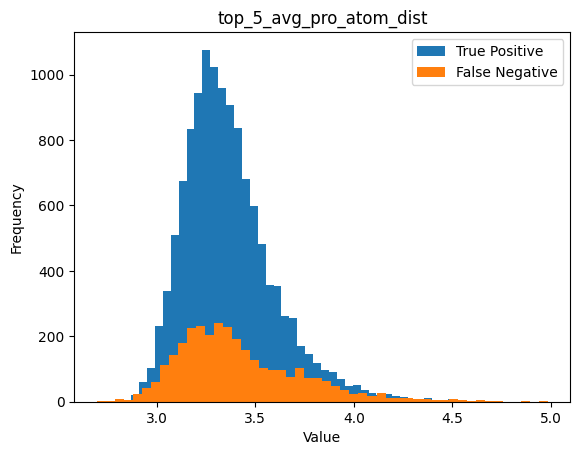

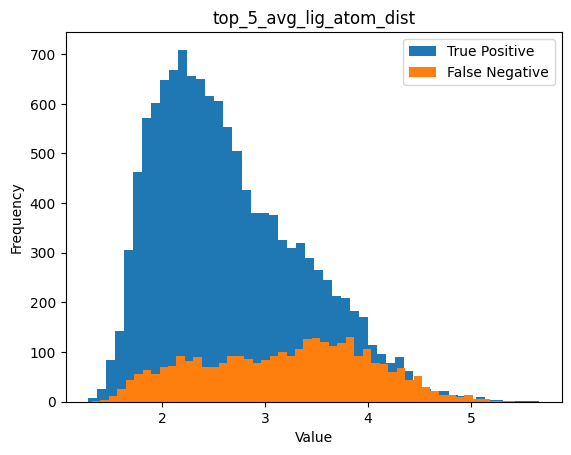

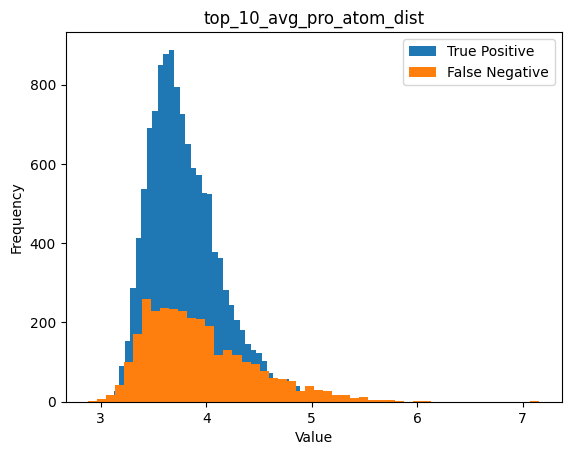

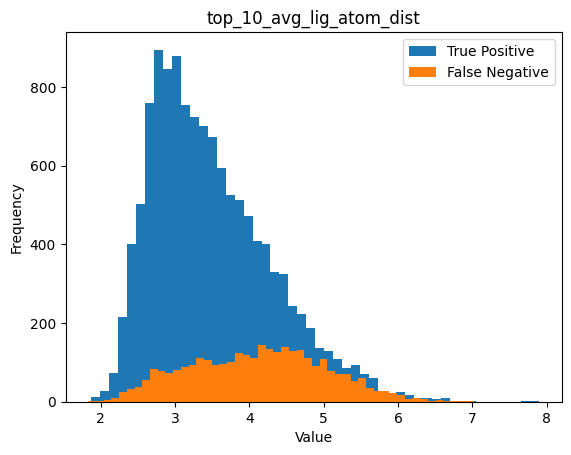

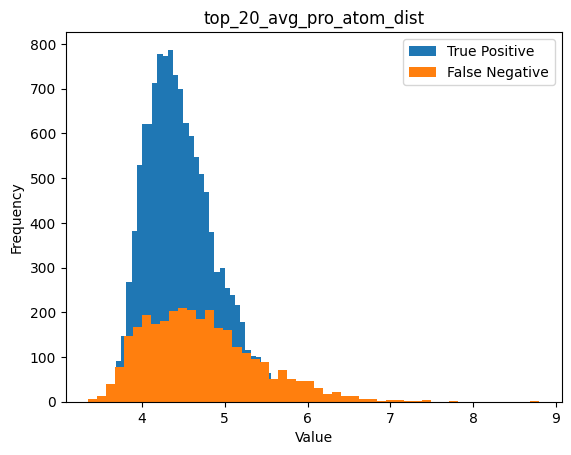

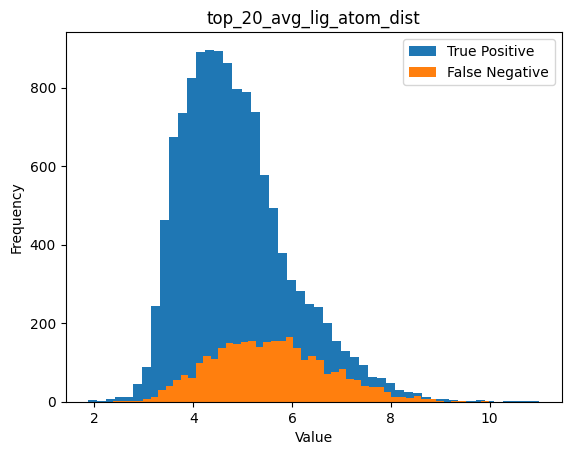

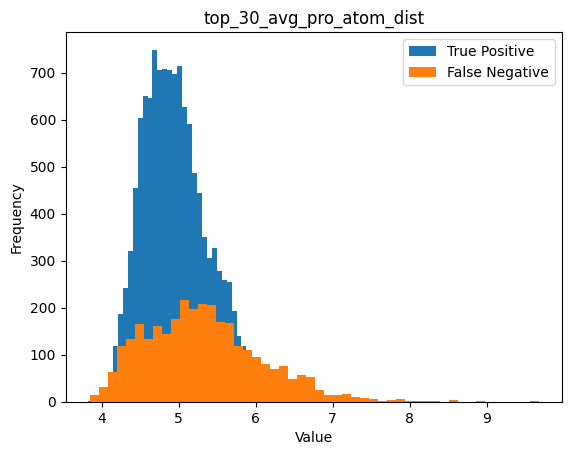

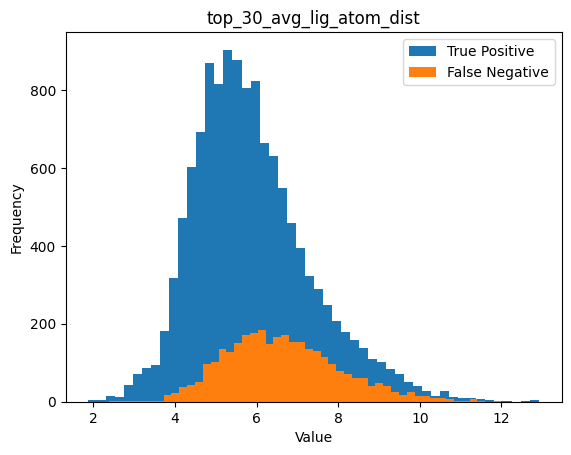

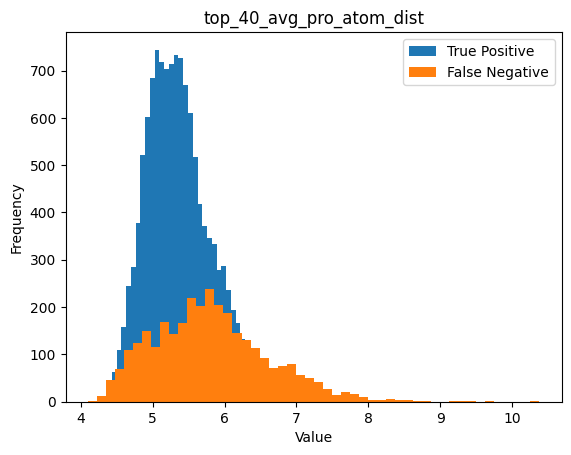

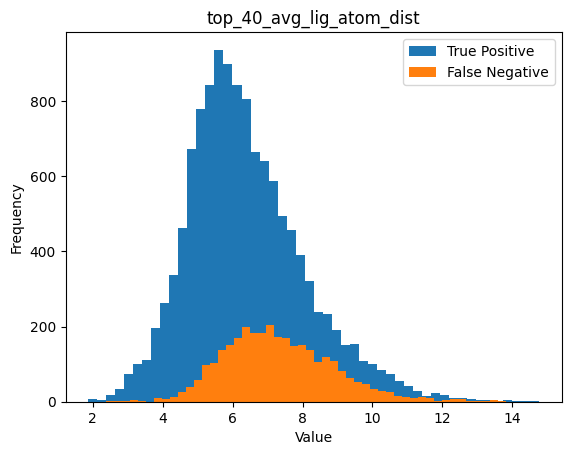

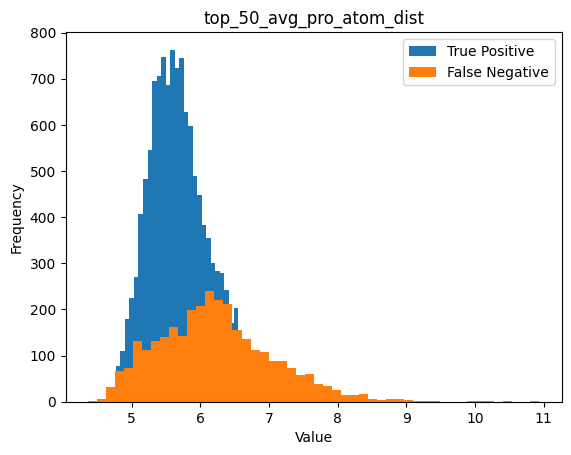

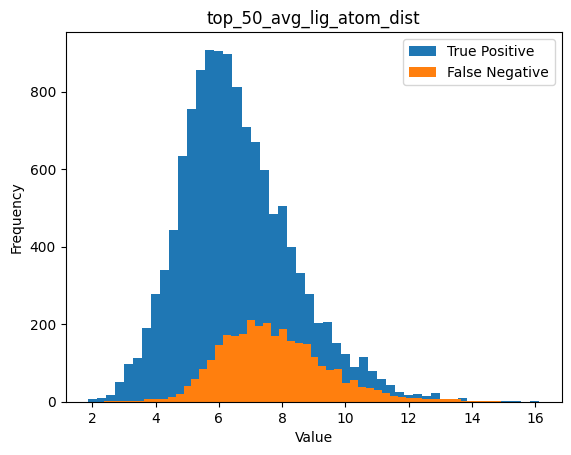

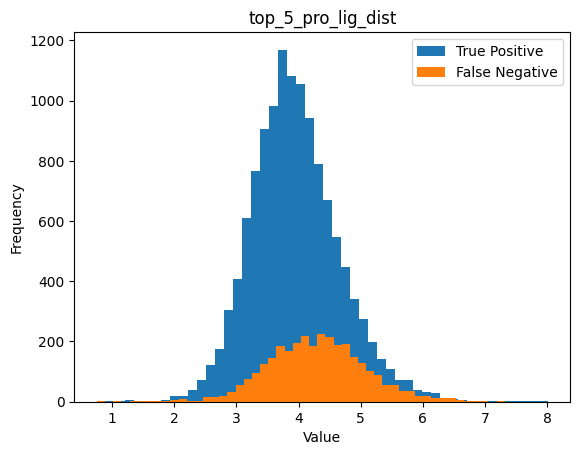

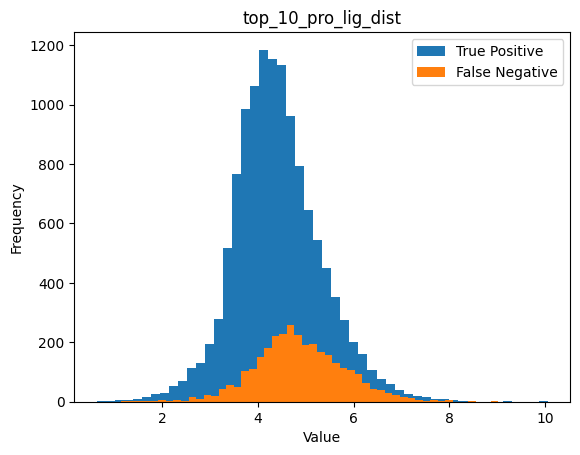

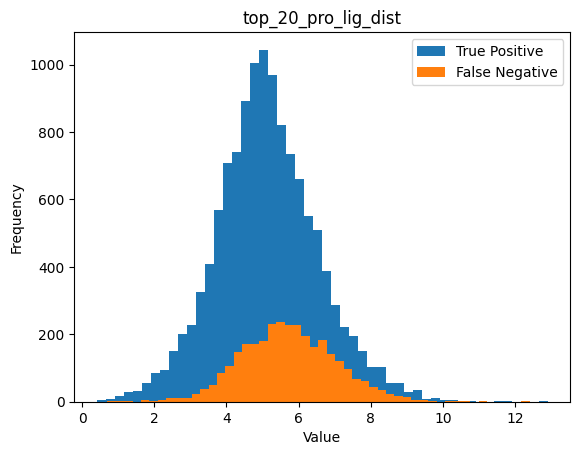

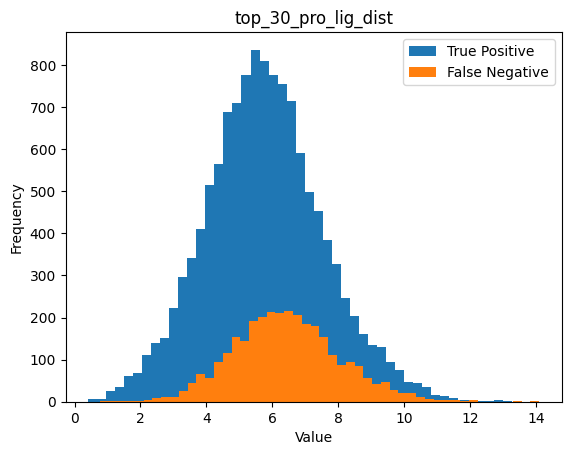

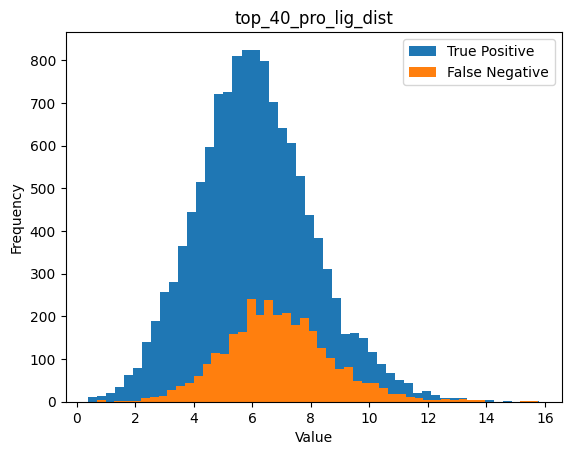

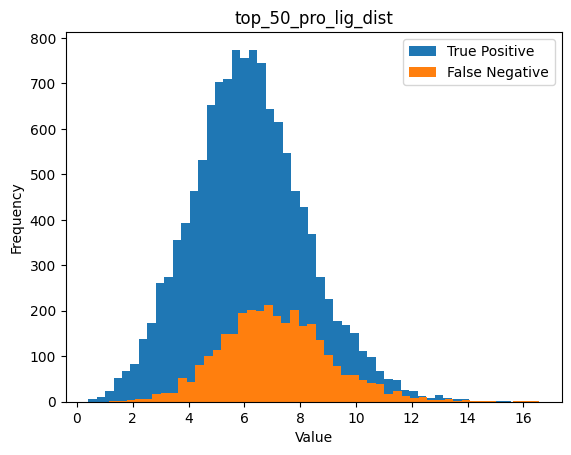

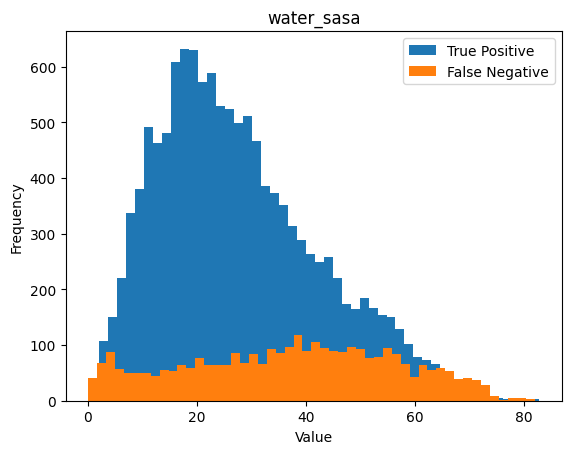

In [7]:
for column_name in columns[4:]:
    plt.hist(result_TP[column_name], bins=50, label='True Positive')
    plt.hist(result_FN[column_name], bins=50, label='False Negative')
    plt.title(column_name)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

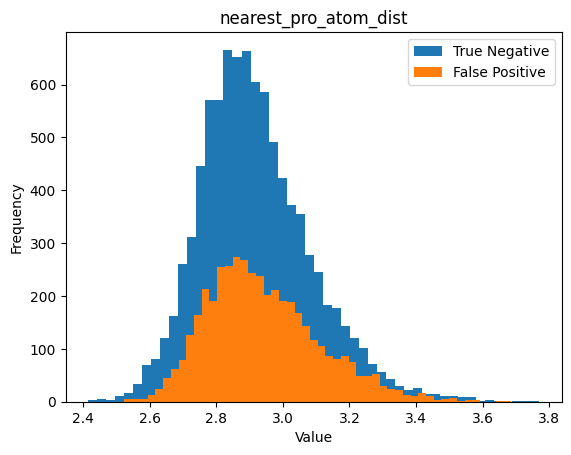

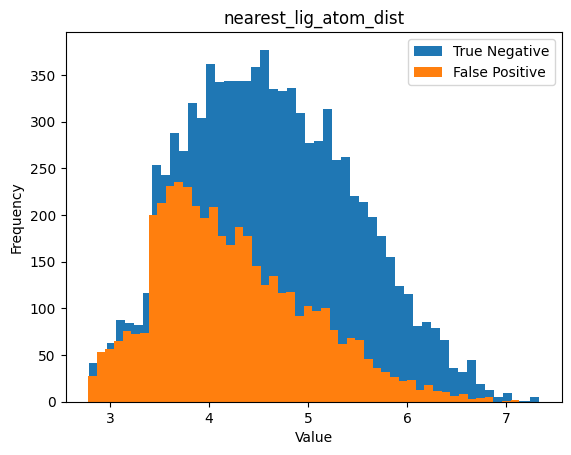

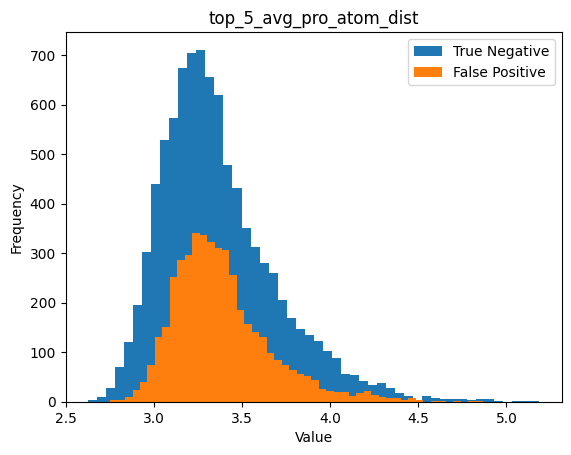

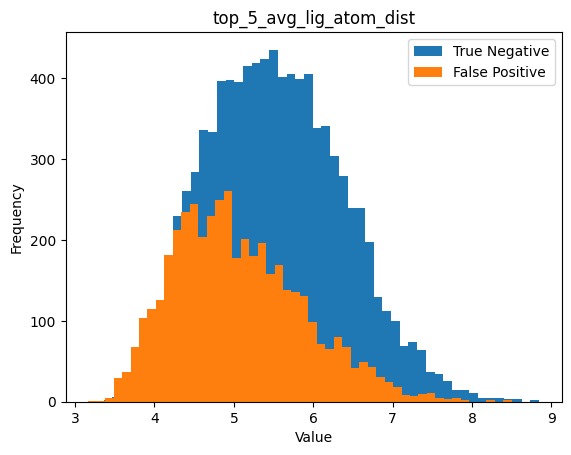

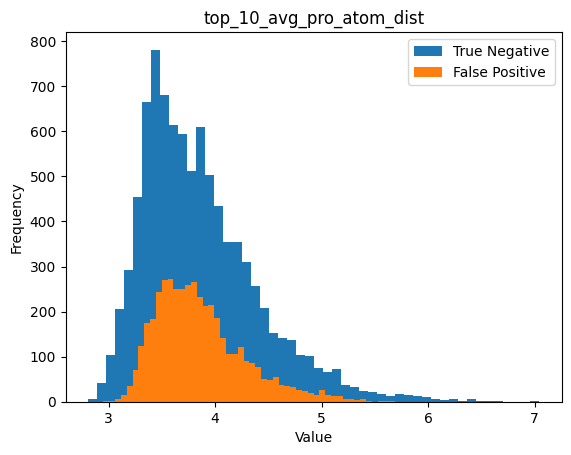

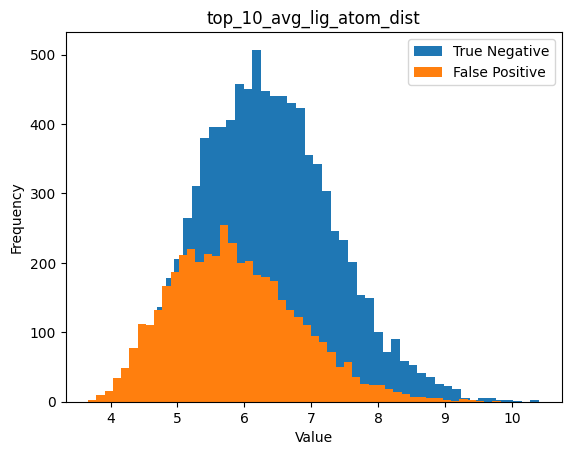

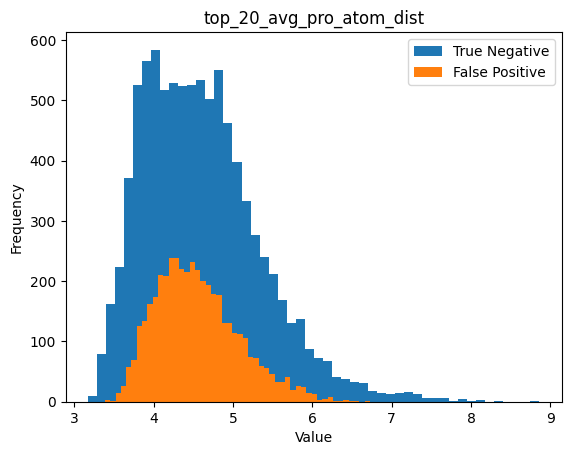

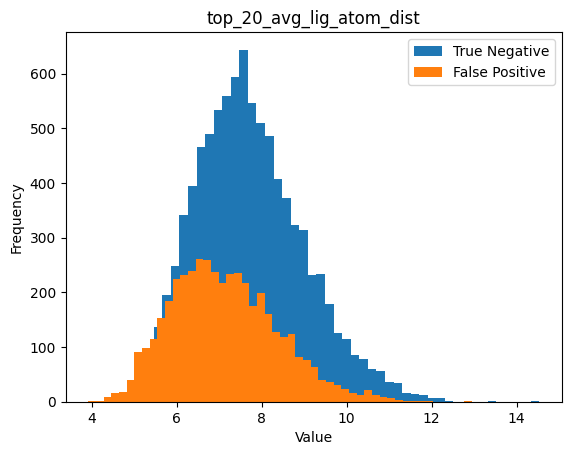

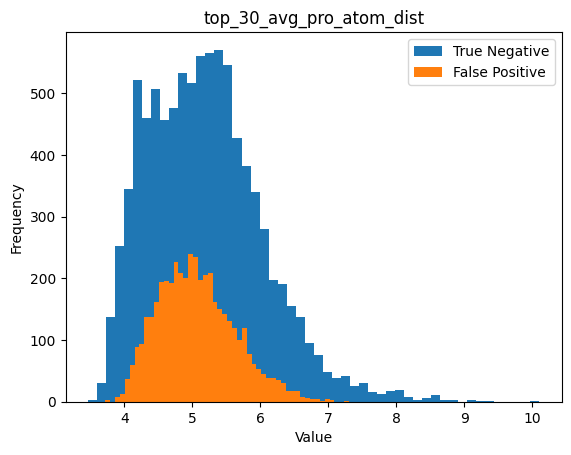

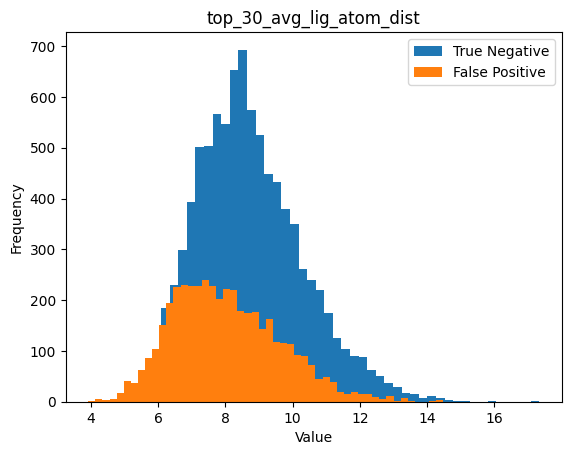

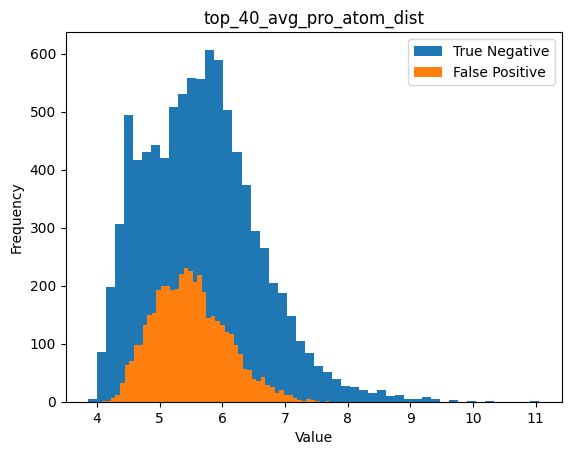

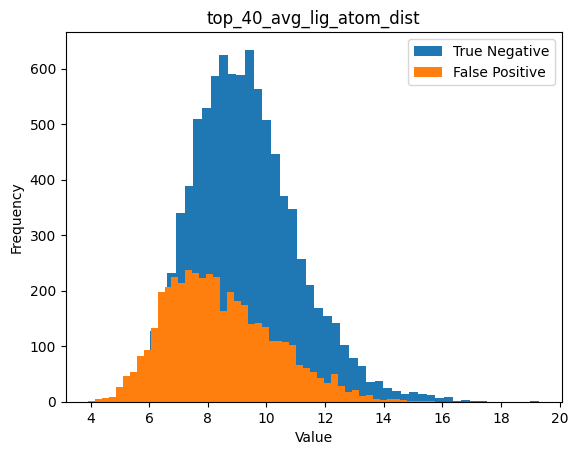

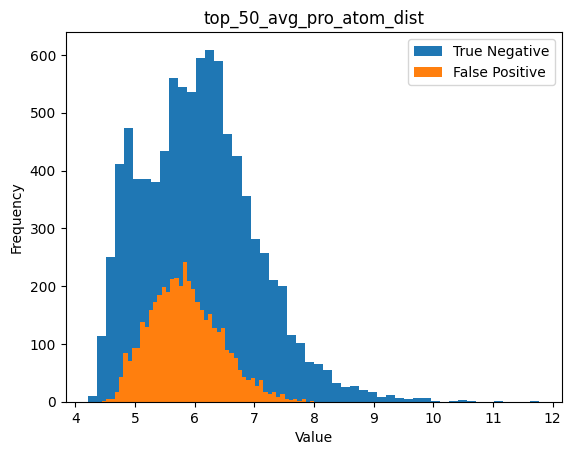

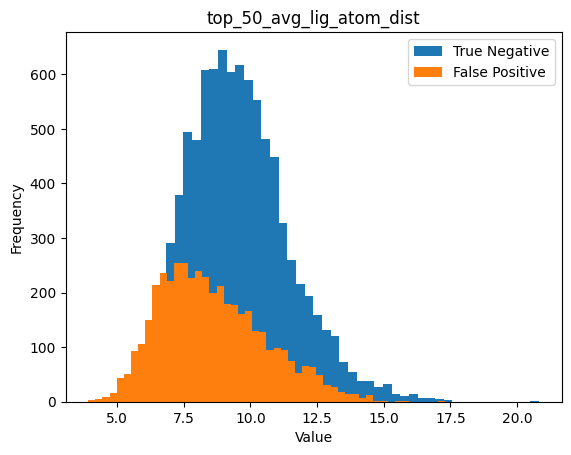

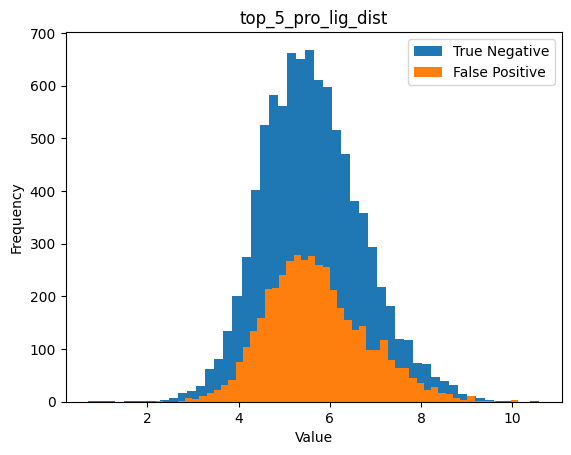

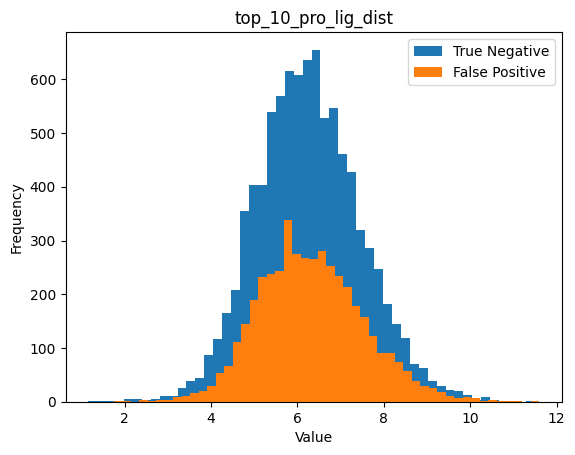

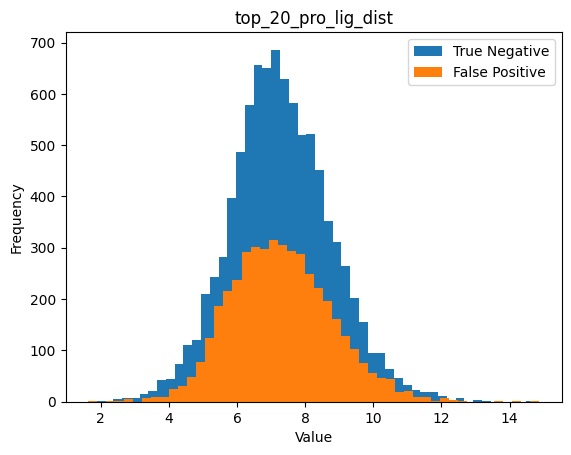

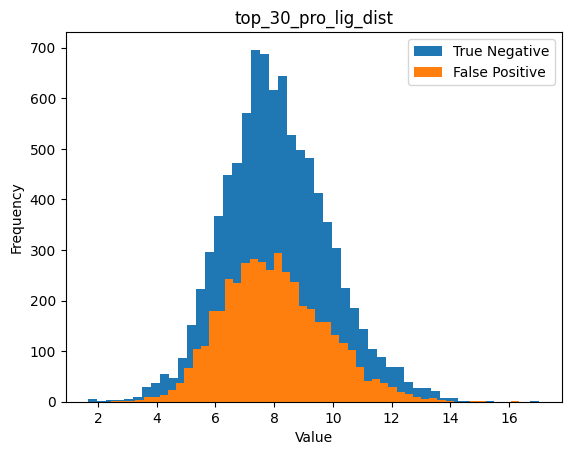

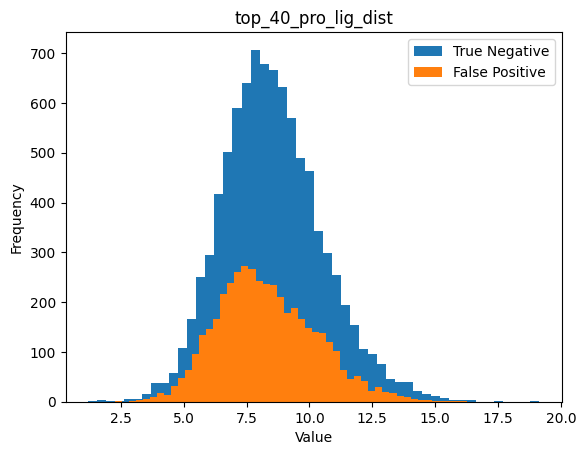

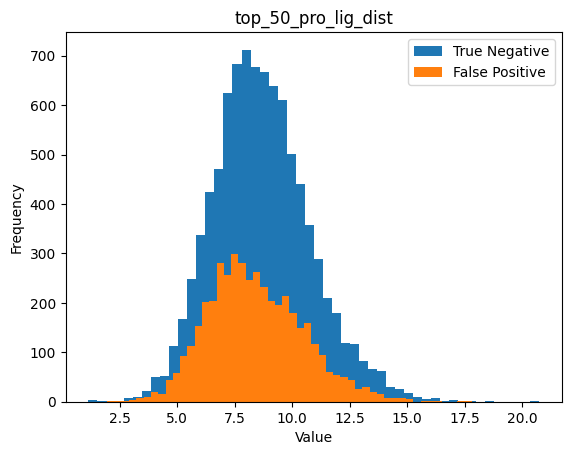

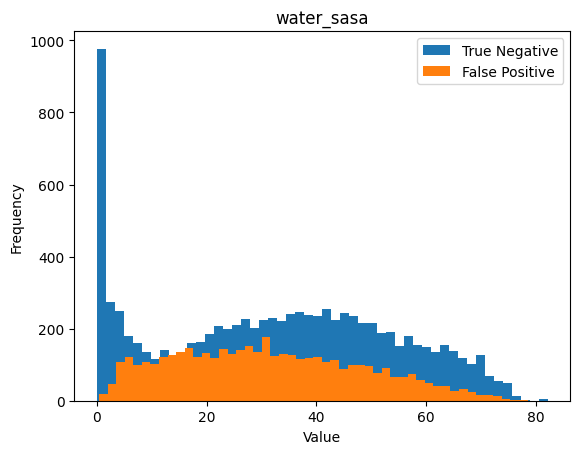

In [8]:
for column_name in columns[4:]:
    
    plt.hist(result_TN[column_name], bins=50, label='True Negative')
    plt.hist(result_FP[column_name], bins=50, label='False Positive')
    plt.title(column_name)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

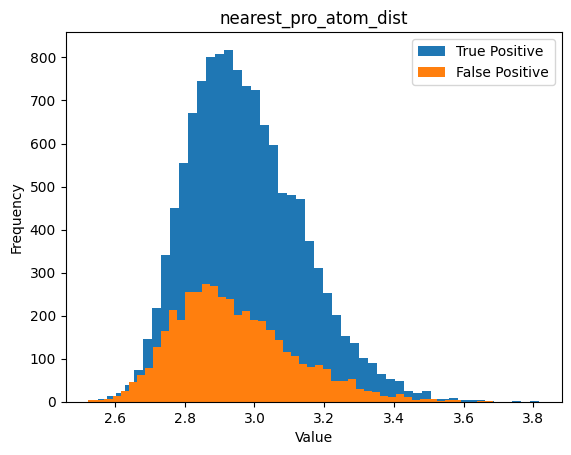

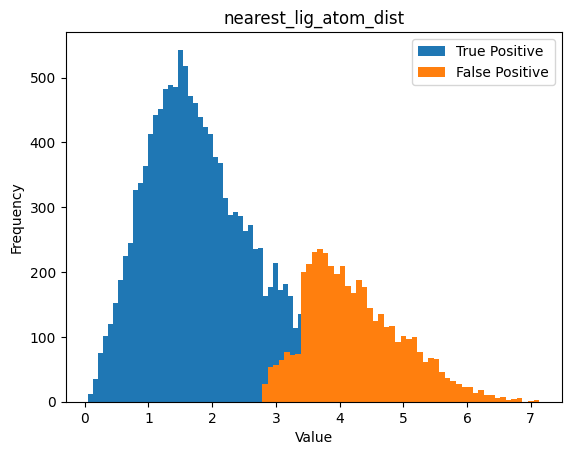

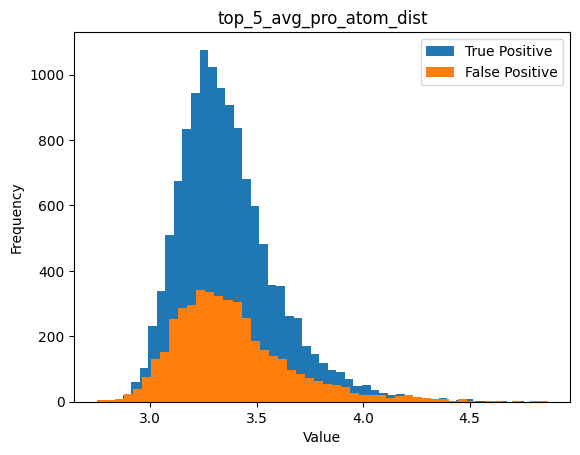

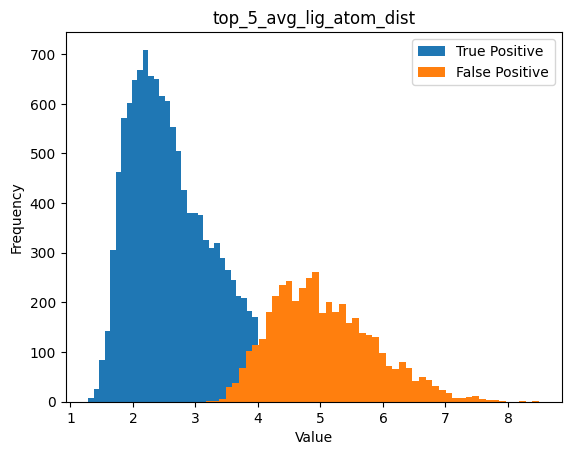

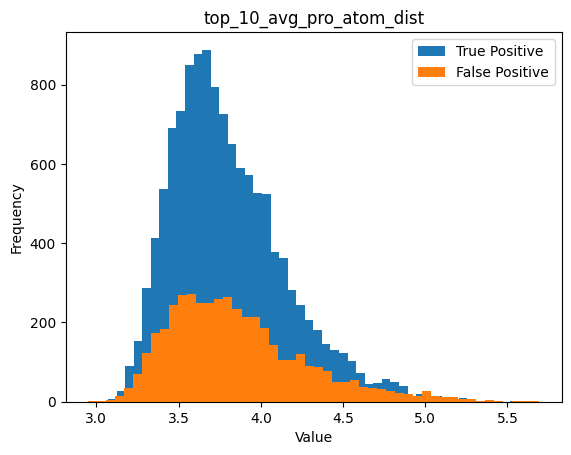

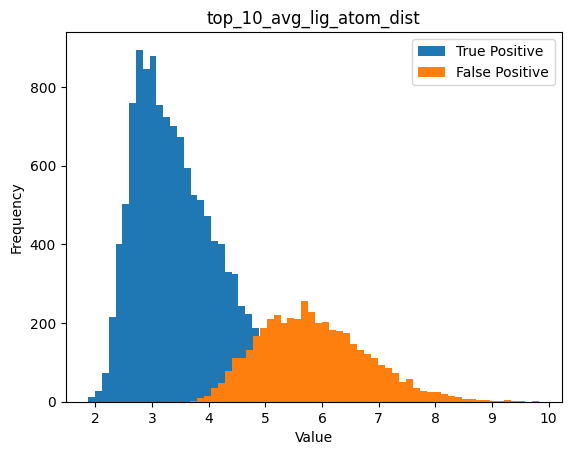

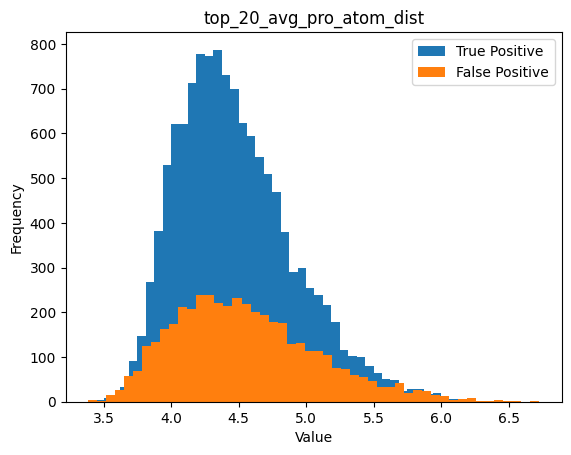

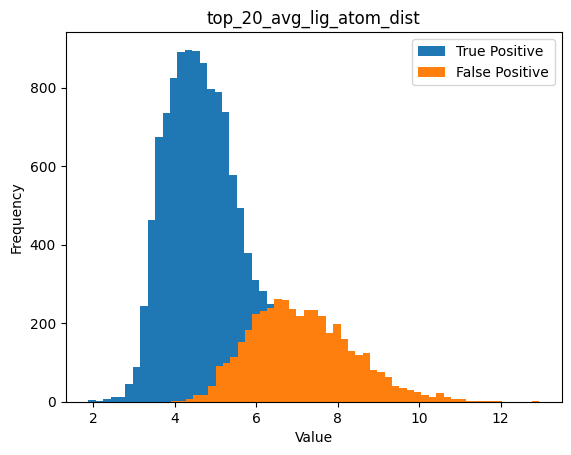

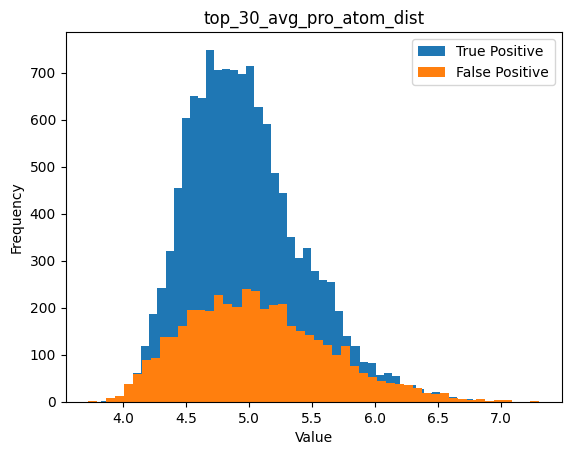

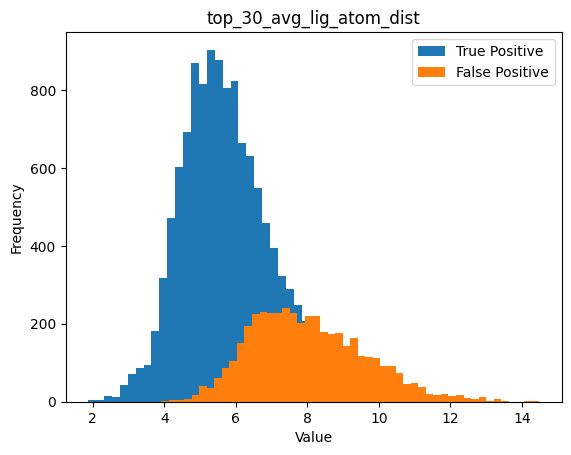

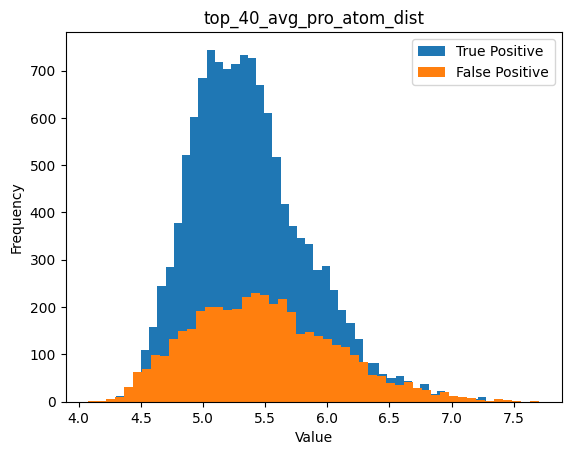

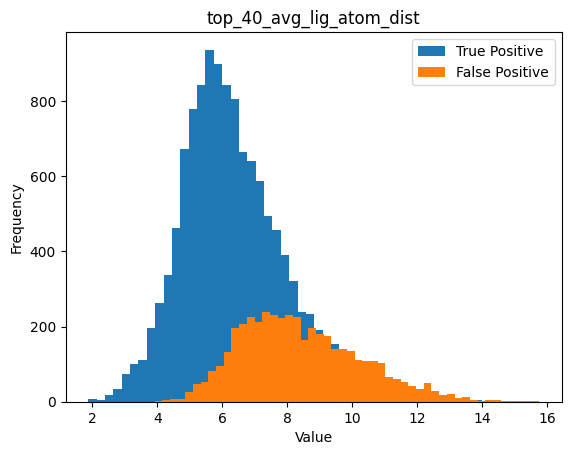

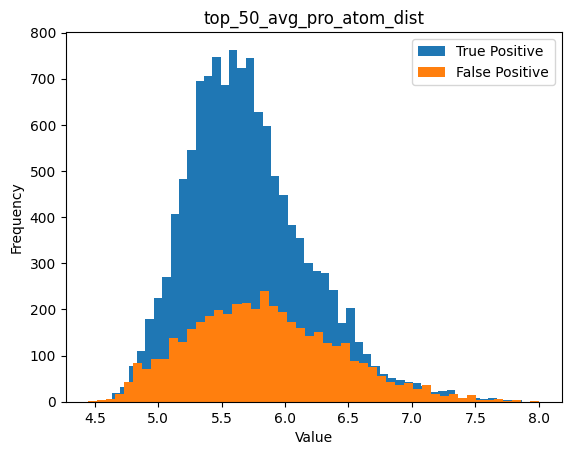

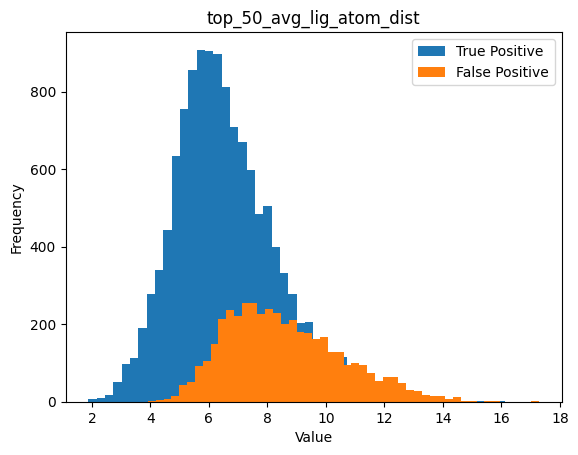

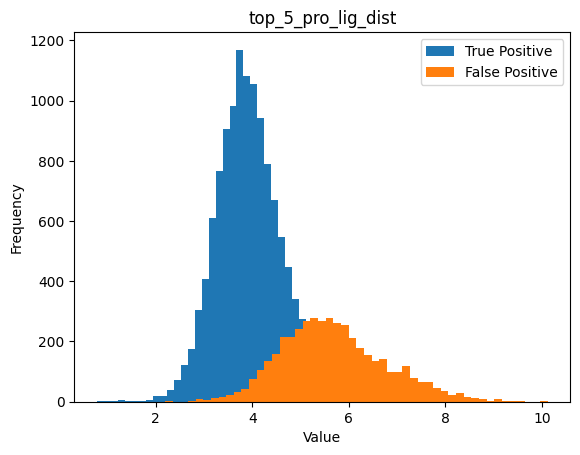

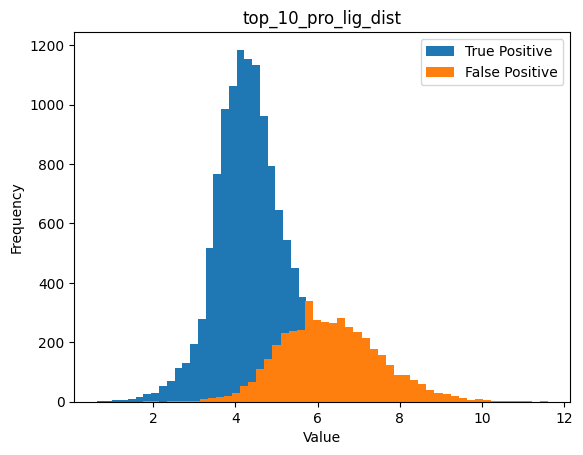

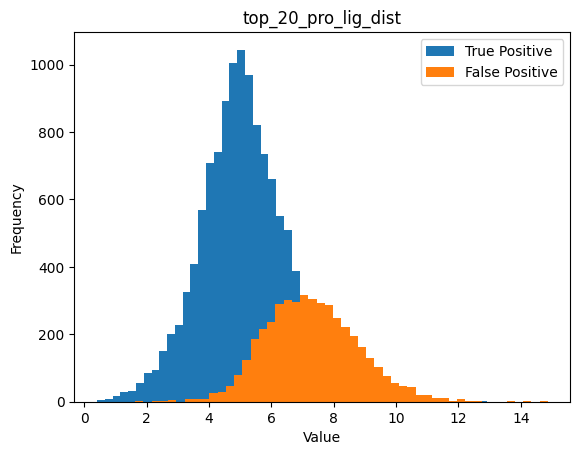

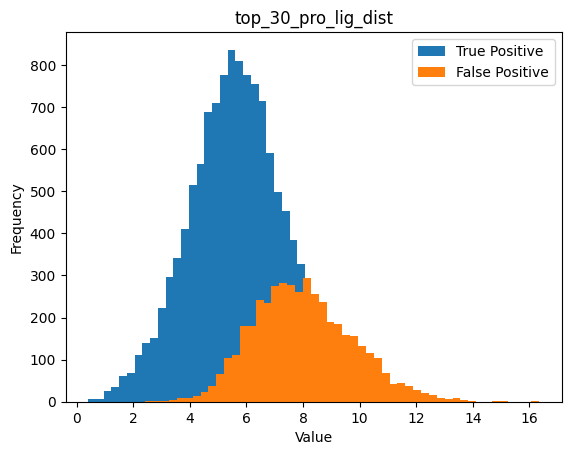

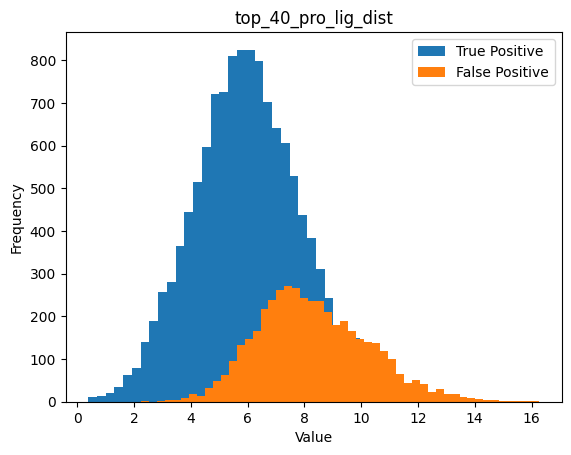

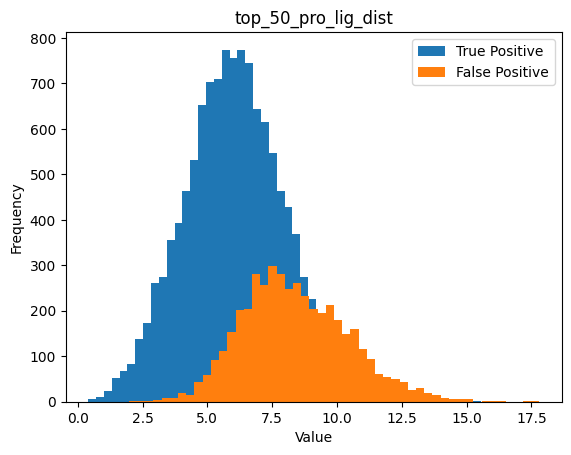

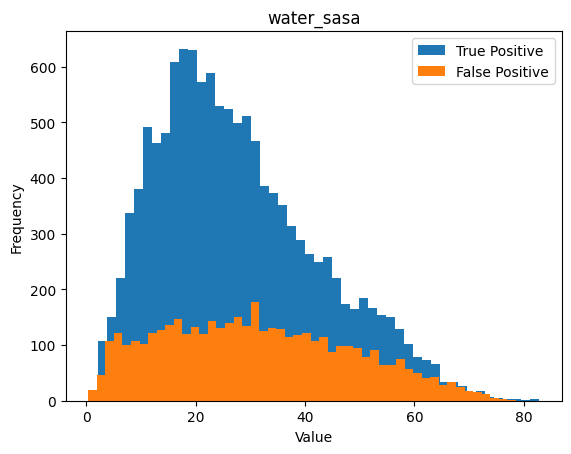

In [9]:
for column_name in columns[4:]:
    plt.hist(result_TP[column_name], bins=50, label='True Positive')
    plt.hist(result_FP[column_name], bins=50, label='False Positive')
    plt.title(column_name)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()